# Google Analytics Customer Revenue Prediction

## INDICE


1\. Transformación de los datos para el análisis

2\. Análisis de Outliers

&nbsp; &nbsp; 2.1\. Error del sistema

&nbsp; &nbsp; &nbsp; &nbsp; 2.1.1\. Transactions

&nbsp; &nbsp; &nbsp; &nbsp; 2.1.2\. Browser

&nbsp; &nbsp; &nbsp; &nbsp; 2.1.3\. Operating System

&nbsp; &nbsp; 2.2\. Cliente

3\. Análisis de Datos

&nbsp; &nbsp; 3.1\. Localización

&nbsp; &nbsp; 3.2\. Device

&nbsp; &nbsp; 3.3\. ChannelGrouping

&nbsp; &nbsp; 3.4\. TrafficSource

&nbsp; &nbsp; 3.5\. VisitStratTime

&nbsp; &nbsp; 3.6\. La regla del 20-80



Presentando los datos iniciales:
    * fullVisitorIdv - A unique identifier for each user of the Google Merchandise Store. 
    * channelGrouping - The channel via which the user came to the Store.
    * date - The date on which the user visited the Store.
    * device - The specifications for the device used to access the Store.
        - browser
        - deviceCategory
        - operatingSystem
    * geoNetwork - This section contains information about the geography of the user.
        - city
        - country
        - region
        - subContinent
    * sessionId - A unique identifier for this visit to the store.
    * socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
    * totals - This section contains aggregate values across the session
        - timeOnSite
        - totalTransactionRevenue
        - transactions
    * trafficSource - This section contains information about the Traffic Source from which the session originated.
        - adContent
        - adPosition
        - campaign
        - isTrueDirect
        - medium
        - source
    * visitNumber - The session number for this user. If this is the first session, then this is set to 1.
    * visitStartTime - The timestamp (expressed as POSIX time).
    * prevPurchases - 1 if the user has already bought in out store
    
### Algunas gáficas serán generadas con www.plot.ly. 

In [1]:
#Estas son las librerías que vamos a utilizar a lo largo de este análisis

import pandas as pd
import pickle
import numpy as np
import warnings
import seaborn as sns
from scipy.stats import kurtosis, skew
import json
import os
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
import random
import squarify
import plotly.plotly as py
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

In [2]:
#cargamos nuestro dataframe desde un archivo pickle. 
filename = "../data/train_v2_cleaned.pkl"


'''cargar archivo pickle'''
with open(filename, 'rb') as f:
   df1 = pickle.load(f)


'''cargar archivo csv'''
#df1 = pd.read_csv(filename, index_col=0)

'cargar archivo csv'

In [3]:
#Visualización de los diferentes tipo de datos que tenemos en nuestro dataframe
df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 21 columns):
channelGrouping            object
fullVisitorId              object
visitNumber                float64
visitStartTime             datetime64[ns]
browser                    object
deviceCategory             object
operatingSystem            object
city                       object
country                    object
region                     object
subContinent               object
adContent                  object
adPosition                 object
campaign                   object
campaignCode               object
isTrueDirect               object
medium                     object
source                     object
timeOnSite                 object
totalTransactionRevenue    float64
transactions               object
dtypes: datetime64[ns](1), float64(2), object(18)
memory usage: 273.7+ MB


# 1. Transformación de los datos para el análisis

En esta sección realizaremos modificaciónes de los datos para poder extrar más información de lagunas de las columnas. Como por ejemplo, la columna "visitStartTime" nos dice la hora en la que el cliente visitó la tienda. Este atributo sería interesante separar la fecha de la hora y desmenuzar ambas y conseguir cruzar el horario con los meses del año, la hora con los días de la semana, etc. 

In [4]:
'''
La siguiente función es para crear nuevas columna en nuestro dataframe 
con datos correspondintes a la hora y la fecha por separado.
'''
def extract_date_info(df, parametro):
    if parametro == "date":
        df["date"] = [d.date() for d in df["visitStartTime"]]
    if parametro == "time":
        df["time"] = [d.time() for d in df["visitStartTime"]]
    if parametro == "day":
        df["day"] = df["visitStartTime"].dt.day
    if parametro == "month":
        df['month'] = df["visitStartTime"].dt.month
    if parametro == "weekday":
        df['weekday'] = df["visitStartTime"].dt.weekday
    if parametro == "weekofyear": 
        df['weekofyear'] = df["visitStartTime"].dt.weekofyear
    return df

In [5]:
#Esta función sencillamente nos devuelve la hora de un formato datetime.
def hr_func(ts):
    return ts.hour

Con las siguentes llamadas lo que hacemos es llamar a la función creada anteriormente y separamos de "visitStartTime" los siguientes datos y los transformamos en nuevas columnas para nuestro dataframe. 

In [6]:
df1 = extract_date_info(df1, 'date')
df1 = extract_date_info(df1, "time")
df1 = extract_date_info(df1, "day")
df1 = extract_date_info(df1, "month")
df1 = extract_date_info(df1, "weekday")
df1 = extract_date_info(df1, "weekofyear")

#conesta llamamos a la función hr_func para que nos extraiga la hora de visitStartTime
df1['hour'] = df1['visitStartTime'].apply(hr_func)

In [7]:
# df1 = nuestro dataframe completo

#Vamos a cambiar el atributo timeOnSite de segundos a minutos 
df1['timeOnSite'] = df1['timeOnSite'].apply(lambda x: float(x)/60)

# purchases = un nuevo dataframe que contiene solo los casos en los que se ha realizado compra
purchases = df1[df1['totalTransactionRevenue']> 0]

# Añadimos una columna con una variable de tipo boolenano siendo True si el cliente compro y False sino
df1['isBuy'] = df1['totalTransactionRevenue']> 0

# 2. Análisis de Outliers

Podemos generar la siguiente hipotesis a cerca de nuestros outliers. Los outliers pueden estar causadas por dos motivos, errores del sistema o como resultado del comportamiento del cliente. 

- **Errores del Sistema:** 
    Pueden ser problemas relacioandados con fallos en las transaciones, el busacador y el sistema operativo.    (transactions, browser y operatingSystem)
    
- **Clientes:**
    Los outliers se corresponden con usuarios con caracteristicas diferentes a la mayoria de usuarios y que compran grandes cantidades de dinero, o lo que es lo mismo, tienen un valor muy alto de totalTransactionRevenue.



In [8]:
# Creamos un dataframe a parte sin los Create a separate dataframe without the outliers
df_outliers = purchases

# Code for removing outliers
Q1 = df_outliers['totalTransactionRevenue'].quantile(0.25)
Q3 = df_outliers['totalTransactionRevenue'].quantile(0.75)
IQR = Q3 - Q1


df_outliers_lower = df_outliers[df_outliers['totalTransactionRevenue'] <(Q1-1.5*IQR)]
df_outliers_upper = df_outliers[df_outliers['totalTransactionRevenue'] >(Q3+1.5*IQR)]

print(df_outliers_lower.shape)
print(df_outliers_upper.shape)

(0, 28)
(2232, 28)


In [9]:
#Como no hay outliers por debajo renombramos df_outliers_upper a simplemente df_outliers
df_outliers = df_outliers_upper.copy()

## 2.1 Errores del sistema:
### 2.1.1 Transactions
Un alto nivel de transacciones teniendo en cuenta esta distribucion podría suponer que hay una gran probabilidad de que estemos frente a un error del sistema o un fallo en la pagina web. Asi que vamos a considerar como errores del sistema a todos los usuarios que tienen más de 3 transaciones.   

In [10]:
df_outliers['transactions'].value_counts()

1     2011
2      159
3       24
4       11
5        8
6        6
7        5
8        2
12       2
10       1
21       1
15       1
25       1
Name: transactions, dtype: int64

In [11]:
# En este caso vamos a eliminar de nuestro df_outliers dataframe aquellas transacciones que sean superiores a 3
df_outliers=df_outliers[(df_outliers['transactions'].astype(float))<=3]


In [12]:
purchases= purchases[purchases['totalTransactionRevenue'] > (Q1-1.5*IQR)]
purchases= purchases[purchases['totalTransactionRevenue'] < (Q3+1.5*IQR)]

In [13]:
df_outliers.shape

(2194, 28)

### 2.1.2 Browser

(16282, 28) (16282, 28)


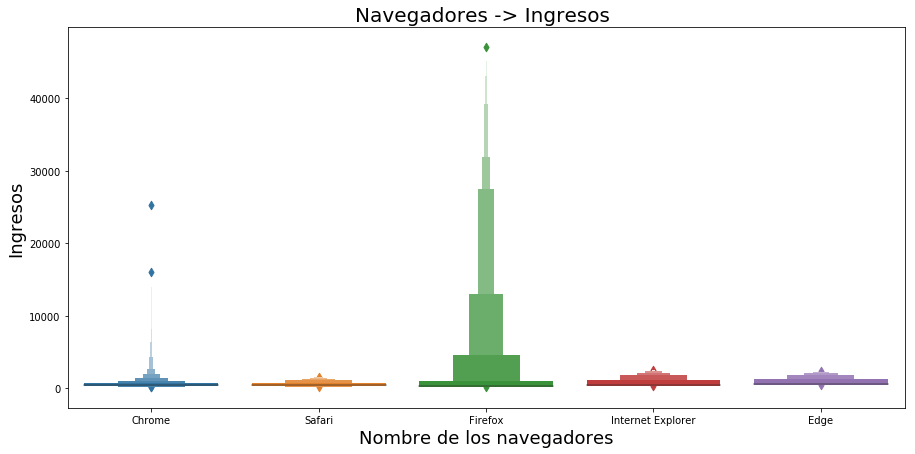

In [14]:
plt.figure(figsize=(15,7))
Browser_Revenue = sns.boxenplot(x='browser', y='totalTransactionRevenue', 
                 data=df_outliers[(df_outliers['browser'].isin((df_outliers['browser'].value_counts()[:7].index.values)))])

print(purchases.shape, purchases.shape)

Browser_Revenue.set_title('Navegadores -> Ingresos ', fontsize=20) # title and fontsize
Browser_Revenue.set_xticklabels(Browser_Revenue.get_xticklabels(),rotation=45) # It's the way to rotate the xticks when we use variable to our graphs
Browser_Revenue.set_xlabel('Nombre de los navegadores', fontsize=18) # Xlabel
Browser_Revenue.set_ylabel('Ingresos', fontsize=18) #Ylabel
plt.xticks(rotation=0) # Simply adjust the text rotation to see it easier.

plt.show()

### 2.1.3 operatingSystem

(16282, 28) (16282, 28)


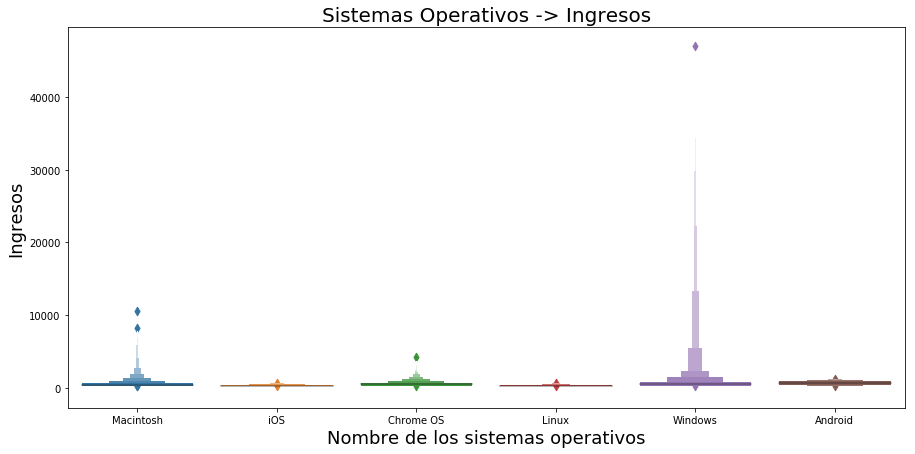

In [15]:

plt.figure(figsize=(15,7))
Browser_Revenue = sns.boxenplot(x='operatingSystem', y='totalTransactionRevenue', 
                 data=df_outliers[(df_outliers['operatingSystem'].isin((df_outliers['operatingSystem'].value_counts()[:7].index.values)))])

print(purchases.shape, purchases.shape)

Browser_Revenue.set_title('Sistemas Operativos -> Ingresos', fontsize=20) 
Browser_Revenue.set_xticklabels(Browser_Revenue.get_xticklabels(),rotation=45) 
Browser_Revenue.set_xlabel('Nombre de los sistemas operativos', fontsize=18)
Browser_Revenue.set_ylabel('Ingresos', fontsize=18) 
plt.xticks(rotation=0) 


plt.show()

A partir de las dos gráficas anteriores podemo observar que gran parte de los outliers encontrados provienen de los usuarios de Windows y del buscador de Firefox. Esta información nos podría llevar a la hipótesis de que haya un "bug" o fallo la web. Esta información podría ser de gran  utilidad para el departamento técnico.

## 2.2 Client


In [16]:
df_outliers_grupped=df_outliers['totalTransactionRevenue'].groupby(df_outliers['fullVisitorId'] )
df_outliers_grupped.sum().sort_values(ascending=False)

fullVisitorId
1957458976293878100    190602.07
9417857471295131045     41810.85
5632276788326171571     16032.75
4471415710206918415     11229.10
3887503293400405088     10559.23
9089132392240687728     10041.75
4984366501121503466      9320.78
7311242886083854158      9234.52
9026840718082010040      8795.72
5469079519715865124      8765.74
2050125810100188362      8689.97
9029794295932939024      7899.35
1735639359262605484      7639.32
7463172420271311409      7260.10
3244885836845029978      7102.88
1956307607572137989      7092.21
79204932396995037        7056.15
7496147812697146114      7003.50
6226617329849661943      6969.70
1814166460229302850      6964.76
6843604665836832262      6461.95
7284466025557220497      5972.19
6010250598436085923      5445.43
566055411938639598       5170.13
7675541360496267931      4985.66
6338803918771114780      4883.30
7965265156545901045      4849.60
2969957690756250633      4739.98
8740176326132717435      4507.66
6236695646664370912      4434

1742 son los numero de outliers que hacen una compra de valor comprendido entre 229 y 190602.07 USD. Tendremos que confrontar estos valores con el precios de los productos que vienden en el sito e-commerce y la  comprada da cada visitor.
Así podemos identificar si estan errores provienen del sistema o se tratan de compras en stock al por mayor. 

A continuación vamos a analizar los usuarios que más compras han realizado. Hemos cogido los 3 que mas compras han hecho. 

In [81]:
#display all rows
pd.set_option('display.max_columns', 100)

usuario1 = df1[df1['fullVisitorId'] == '5632276788326171571']
usuario1.sort_values(by=['visitStartTime'])

,channelGrouping,fullVisitorId,visitNumber,visitStartTime,browser,deviceCategory,operatingSystem,city,country,region,subContinent,adContent,adPosition,campaign,campaignCode,isTrueDirect,medium,source,timeOnSite,totalTransactionRevenue,transactions,date,time,day,month,weekday,weekofyear,hour,isBuy
116084,Direct,5632276788326171571,1.0,2016-08-05 19:12:33,Chrome,desktop,Windows,Salem,United States,Virginia,Northern America,NaN,NaN,(not set),NaN,True,(none),(direct),19.966667,0.00,NaN,2016-08-05,19:12:33,5,8,4,31,19,False
913881,Direct,5632276788326171571,2.0,2016-08-17 19:44:32,Chrome,desktop,Windows,Salem,United States,Virginia,Northern America,NaN,NaN,(not set),NaN,True,(none),(direct),0.066667,0.00,NaN,2016-08-17,19:44:32,17,8,2,33,19,False
838384,Direct,5632276788326171571,3.0,2016-08-18 12:28:46,Chrome,desktop,Windows,Salem,United States,Virginia,Northern America,NaN,NaN,(not set),NaN,True,(none),(direct),NaN,0.00,NaN,2016-08-18,12:28:46,18,8,3,33,12,False
47297,Direct,5632276788326171571,4.0,2016-08-22 13:31:40,Chrome,desktop,Windows,Salem,United States,Virginia,Northern America,NaN,NaN,(not set),NaN,True,(none),(direct),NaN,0.00,NaN,2016-08-22,13:31:40,22,8,0,34,13,False
676485,Direct,5632276788326171571,5.0,2016-09-16 14:20:43,Chrome,desktop,Windows,Salem,United States,Virginia,Northern America,NaN,NaN,(not set),NaN,True,(none),(direct),24.766667,16032.75,1,2016-09-16,14:20:43,16,9,4,37,14,True
313380,Direct,5632276788326171571,6.0,2016-11-17 13:18:02,Chrome,desktop,Windows,Salem,United States,Virginia,Northern America,NaN,NaN,(not set),NaN,True,(none),(direct),0.116667,0.00,NaN,2016-11-17,13:18:02,17,11,3,46,13,False


In [18]:
usuario1 = usuario1[usuario1['isBuy'] == True]
usuario1 

,channelGrouping,fullVisitorId,visitNumber,visitStartTime,browser,deviceCategory,operatingSystem,city,country,region,...,totalTransactionRevenue,transactions,date,time,day,month,weekday,weekofyear,hour,isBuy
676485,Direct,5632276788326171571,5.0,2016-09-16 14:20:43,Chrome,desktop,Windows,Salem,United States,Virginia,...,16032.75,1,2016-09-16,14:20:43,16,9,4,37,14,True


Hemos podido ver que este usuario visitó la tienda varías veces en un período corto de tiempo. Solo realizó una transacción por el valor de 16032,75 USD y que en esa compra se mantuvo en la sesión durante 24 minutos. Podemos ver que el cliente se mantuvo en la sesion durante 19 minutos. 

Con estos datos, podemos generar una hipótesis basada en que una compra tan grande no encaja en que sea para un particular. Por lo que nos hace llegar a la conclusión de que pueda tratarse de una inversión para un evento o algo similar. 

In [82]:
usuario2 = df1[df1['fullVisitorId'] == '1957458976293878100']
print(usuario2.shape)

usuario2.sort_values(by=['visitStartTime'])

(400, 29)


,channelGrouping,fullVisitorId,visitNumber,visitStartTime,browser,deviceCategory,operatingSystem,city,country,region,subContinent,adContent,adPosition,campaign,campaignCode,isTrueDirect,medium,source,timeOnSite,totalTransactionRevenue,transactions,date,time,day,month,weekday,weekofyear,hour,isBuy
1539818,Organic Search,1957458976293878100,38.0,2016-08-04 16:33:57,Firefox,desktop,Windows,not available in demo dataset,United States,United States,Northern America,NaN,NaN,(not set),NaN,NaN,organic,google,2.300000,0.00,NaN,2016-08-04,16:33:57,4,8,3,31,16,False
117617,Organic Search,1957458976293878100,39.0,2016-08-05 17:54:28,Firefox,desktop,Windows,Smyrna,United States,Georgia,Northern America,NaN,NaN,(not set),NaN,True,organic,google,0.050000,0.00,NaN,2016-08-05,17:54:28,5,8,4,31,17,False
610557,Organic Search,1957458976293878100,40.0,2016-08-09 12:05:57,Firefox,desktop,Windows,not available in demo dataset,United States,United States,Northern America,NaN,NaN,(not set),NaN,True,organic,google,0.250000,0.00,NaN,2016-08-09,12:05:57,9,8,1,32,12,False
611499,Organic Search,1957458976293878100,41.0,2016-08-09 15:59:43,Firefox,desktop,Windows,not available in demo dataset,United States,United States,Northern America,NaN,NaN,(not set),NaN,True,organic,google,3.666667,0.00,NaN,2016-08-09,15:59:43,9,8,1,32,15,False
1295536,Organic Search,1957458976293878100,42.0,2016-08-10 19:51:31,Firefox,desktop,Windows,not available in demo dataset,United States,United States,Northern America,NaN,NaN,(not set),NaN,True,organic,google,5.683333,0.00,NaN,2016-08-10,19:51:31,10,8,2,32,19,False
1294760,Organic Search,1957458976293878100,43.0,2016-08-10 21:16:15,Firefox,desktop,Windows,not available in demo dataset,United States,United States,Northern America,NaN,NaN,(not set),NaN,True,organic,google,0.166667,0.00,NaN,2016-08-10,21:16:15,10,8,2,32,21,False
1295051,Organic Search,1957458976293878100,44.0,2016-08-10 22:02:30,Firefox,desktop,Windows,not available in demo dataset,United States,United States,Northern America,NaN,NaN,(not set),NaN,True,organic,google,0.366667,0.00,NaN,2016-08-10,22:02:30,10,8,2,32,22,False
224011,Organic Search,1957458976293878100,45.0,2016-08-11 16:10:24,Firefox,desktop,Windows,not available in demo dataset,United States,United States,Northern America,NaN,NaN,(not set),NaN,True,organic,google,5.316667,0.00,NaN,2016-08-11,16:10:24,11,8,3,32,16,False
223551,Organic Search,1957458976293878100,46.0,2016-08-11 16:59:13,Firefox,desktop,Windows,not available in demo dataset,United States,United States,Northern America,NaN,NaN,(not set),NaN,True,organic,google,0.266667,0.00,NaN,2016-08-11,16:59:13,11,8,3,32,16,False
1279366,Organic Search,1957458976293878100,47.0,2016-08-12 13:08:32,Firefox,desktop,Windows,not available in demo dataset,United States,United States,Northern America,NaN,NaN,(not set),NaN,True,organic,google,21.200000,0.00,NaN,2016-08-12,13:08:32,12,8,4,32,13,False


In [20]:
usuario2 = usuario2[usuario2['isBuy'] == True]
print(usuario2.shape)

usuario2.sort_values(by=['visitStartTime'])


(24, 29)


,channelGrouping,fullVisitorId,visitNumber,visitStartTime,browser,deviceCategory,operatingSystem,city,country,region,...,totalTransactionRevenue,transactions,date,time,day,month,weekday,weekofyear,hour,isBuy
1172898,Direct,1957458976293878100,181.0,2017-02-14 18:30:28,Firefox,desktop,Windows,not available in demo dataset,United States,United States,...,17859.50,1,2017-02-14,18:30:28,14,2,1,7,18,True
901577,Display,1957458976293878100,237.0,2017-03-24 18:36:00,Firefox,desktop,Windows,not available in demo dataset,United States,United States,...,8680.83,1,2017-03-24,18:36:00,24,3,4,12,18,True
661872,Display,1957458976293878100,243.0,2017-04-05 20:19:40,Firefox,desktop,Windows,not available in demo dataset,United States,United States,...,47082.06,2,2017-04-05,20:19:40,5,4,2,14,20,True
608189,Display,1957458976293878100,245.0,2017-04-07 15:20:02,Firefox,desktop,Windows,not available in demo dataset,United States,United States,...,6831.96,1,2017-04-07,15:20:02,7,4,4,14,15,True
608078,Display,1957458976293878100,246.0,2017-04-07 20:35:58,Firefox,desktop,Windows,not available in demo dataset,United States,United States,...,3030.20,1,2017-04-07,20:35:58,7,4,4,14,20,True
519146,Display,1957458976293878100,258.0,2017-04-18 15:05:22,Firefox,desktop,Windows,not available in demo dataset,United States,United States,...,32153.82,3,2017-04-18,15:05:22,18,4,1,16,15,True
541395,Display,1957458976293878100,259.0,2017-04-19 15:40:59,Firefox,desktop,Windows,not available in demo dataset,United States,United States,...,3677.92,1,2017-04-19,15:40:59,19,4,2,16,15,True
1631903,Display,1957458976293878100,293.0,2017-05-26 18:29:28,Firefox,desktop,Windows,not available in demo dataset,United States,United States,...,416.96,1,2017-05-26,18:29:28,26,5,4,21,18,True
625106,Display,1957458976293878100,295.0,2017-06-01 18:35:43,Firefox,desktop,Windows,not available in demo dataset,United States,United States,...,242.40,1,2017-06-01,18:35:43,1,6,3,22,18,True
545612,Display,1957458976293878100,296.0,2017-06-02 19:38:40,Firefox,desktop,Windows,not available in demo dataset,United States,United States,...,1428.25,1,2017-06-02,19:38:40,2,6,4,22,19,True


In [21]:
#usuario2.to_csv("usuario.csv")

En ese segundo usuario vemos que realiza visitas a la página 400 veces a los largo de lso dos años. Compra cantidades tanto muy grande como algo menores. También podemos observar que solo visita la tienda entre semana. Esto se puede comprobar en una de nuestras columnnas llamadas "weekday" que hemos transformado anteriormente en la que "0" indica lunes y "6" domingo. Solo aparecen días entre 0 y 4. 

Con los datos que hemos observado anteriormente, generamos la hipótesis de que se trata de un cliente que compra para una tienda. Puesto que la gran mayoría de las visitas y las compras se realizan entre semana. Además, se hacen compras muy grandes como en intervalos periódicos de tiempo y quizás compras más pequeñas par aajustarse a la demanda. 


In [22]:
usuario3 = df1[df1['fullVisitorId'] == '9417857471295131045']
print(usuario3.shape)

usuario3.sort_values(by=['visitStartTime'])

(21, 29)


,channelGrouping,fullVisitorId,visitNumber,visitStartTime,browser,deviceCategory,operatingSystem,city,country,region,...,totalTransactionRevenue,transactions,date,time,day,month,weekday,weekofyear,hour,isBuy
1353937,Direct,9417857471295131045,1.0,2017-07-13 13:08:35,Chrome,desktop,Windows,not available in demo dataset,United States,United States,...,14060.31,2,2017-07-13,13:08:35,13,7,3,28,13,True
1353689,Direct,9417857471295131045,2.0,2017-07-13 18:34:57,Chrome,desktop,Windows,not available in demo dataset,United States,United States,...,0.00,NaN,2017-07-13,18:34:57,13,7,3,28,18,False
344736,Direct,9417857471295131045,3.0,2017-07-14 14:52:40,Chrome,desktop,Windows,not available in demo dataset,United States,United States,...,0.00,NaN,2017-07-14,14:52:40,14,7,4,28,14,False
344068,Direct,9417857471295131045,4.0,2017-07-14 18:30:25,Chrome,desktop,Windows,not available in demo dataset,United States,United States,...,0.00,NaN,2017-07-14,18:30:25,14,7,4,28,18,False
880296,Direct,9417857471295131045,5.0,2017-07-17 12:33:28,Chrome,desktop,Windows,not available in demo dataset,United States,United States,...,0.00,NaN,2017-07-17,12:33:28,17,7,0,29,12,False
879571,Direct,9417857471295131045,6.0,2017-07-17 19:11:35,Chrome,desktop,Windows,not available in demo dataset,United States,United States,...,0.00,NaN,2017-07-17,19:11:35,17,7,0,29,19,False
880488,Direct,9417857471295131045,7.0,2017-07-17 22:55:30,Chrome,desktop,Windows,not available in demo dataset,United States,United States,...,288.88,1,2017-07-17,22:55:30,17,7,0,29,22,True
1657678,Direct,9417857471295131045,8.0,2017-07-18 19:00:09,Chrome,desktop,Windows,not available in demo dataset,United States,United States,...,25249.26,2,2017-07-18,19:00:09,18,7,1,29,19,True
1005527,Direct,9417857471295131045,9.0,2017-07-20 18:50:24,Chrome,desktop,Windows,not available in demo dataset,United States,United States,...,0.00,NaN,2017-07-20,18:50:24,20,7,3,29,18,False
797428,Direct,9417857471295131045,10.0,2017-07-21 17:20:34,Chrome,desktop,Windows,not available in demo dataset,United States,United States,...,1337.28,2,2017-07-21,17:20:34,21,7,4,29,17,True


In [23]:
usuario3 = usuario3[usuario3['isBuy'] == True]
print(usuario3.shape)

usuario3.sort_values(by=['visitStartTime'])

(5, 29)


,channelGrouping,fullVisitorId,visitNumber,visitStartTime,browser,deviceCategory,operatingSystem,city,country,region,...,totalTransactionRevenue,transactions,date,time,day,month,weekday,weekofyear,hour,isBuy
1353937,Direct,9417857471295131045,1.0,2017-07-13 13:08:35,Chrome,desktop,Windows,not available in demo dataset,United States,United States,...,14060.31,2,2017-07-13,13:08:35,13,7,3,28,13,True
880488,Direct,9417857471295131045,7.0,2017-07-17 22:55:30,Chrome,desktop,Windows,not available in demo dataset,United States,United States,...,288.88,1,2017-07-17,22:55:30,17,7,0,29,22,True
1657678,Direct,9417857471295131045,8.0,2017-07-18 19:00:09,Chrome,desktop,Windows,not available in demo dataset,United States,United States,...,25249.26,2,2017-07-18,19:00:09,18,7,1,29,19,True
797428,Direct,9417857471295131045,10.0,2017-07-21 17:20:34,Chrome,desktop,Windows,not available in demo dataset,United States,United States,...,1337.28,2,2017-07-21,17:20:34,21,7,4,29,17,True
475496,Direct,9417857471295131045,19.0,2017-07-28 15:22:24,Chrome,desktop,Windows,not available in demo dataset,United States,United States,...,875.12,2,2017-07-28,15:22:24,28,7,4,30,15,True


En este último cliente observamos que realiza tanto las vistas comom las compras en un rango de 40 días comprendidos en los meses de Julio y Agosto. En este tiempo el ciente realiza 5 compras de valores muy elevados y, al igual que los dos clientes anteriores, solo realiza las visitas y las compras entre semana. 


Description of SubContinent count: 
Northern America    2119
South America         22
Eastern Asia          11
Australasia            7
Northern Europe        7
Southeast Asia         5
Western Europe         5
Central America        3
Name: subContinent, dtype: int64


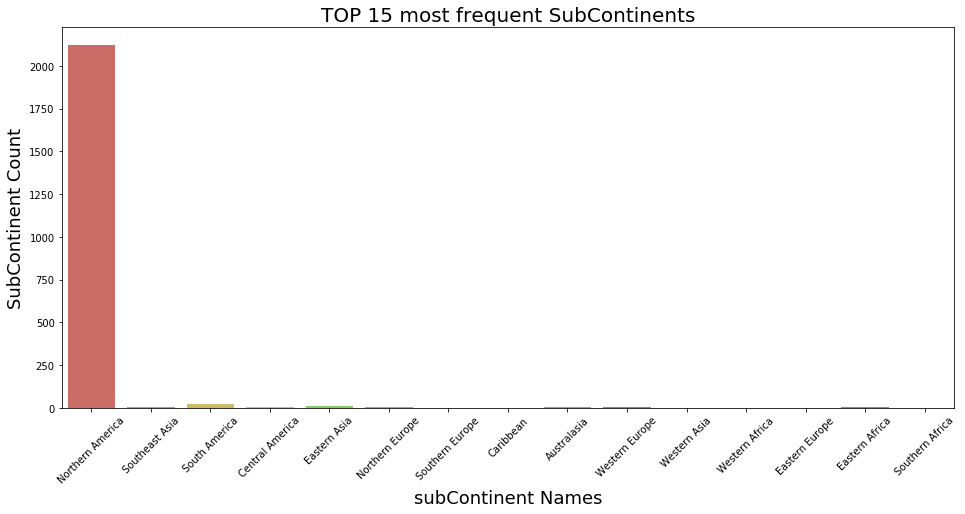

In [83]:
# first lets see and histogram of the subcontinents we have in our dataset. 
# the top 8 of browsers represent % of total
print("Description of SubContinent count: ")
print(df_outliers['subContinent'].value_counts()[:8]) # printing the top 7 percentage of browsers

# seting the graph size
plt.figure(figsize=(16,7))

# let explore the browser used by users
sns.countplot(df_outliers[df_outliers['subContinent']\
                       .isin(df_outliers['subContinent']\
                             .value_counts()[:15].index.values)]['subContinent'], palette="hls") # It's a module to count the category's
plt.title("TOP 15 most frequent SubContinents", fontsize=20) # seting the title size
plt.xlabel("subContinent Names", fontsize=18) # seting the x label size
plt.ylabel("SubContinent Count", fontsize=18) # seting the y label size
plt.xticks(rotation=45) # Adjust the xticks, rotating the labels

plt.show() #use plt.show to render the graph that we did above

Near the whole number of high value transaction are purchased by Northern America. 
Now we focus more in the exacly position of those customers.

In [84]:
numero_colores = 50 

# esto será capaz de generar muchos colores desde valores hexadecimales
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(numero_colores)]
'''
Primero vamos a crear un dataframe que sea en el que guardemos las ciudades sin los que no corresponden 
a ciudades. 

'''

city_squareBox = df_outliers["city"].value_counts() # conteo de las visitas de cada ciudad
print("Most frequent cities in America: " )
print(city_squareBox[:10])


#city_squareBox = city_squareBox.replace('(not set)', np.nan)


#creando un nuevo dataframe sin esos valores
city_squareBox = df_outliers[df_outliers.city != "(not set)"]
city_squareBox = city_squareBox[city_squareBox.city != "not available in demo dataset"]

%matplotlib inline

Most frequent cities in America: 
not available in demo dataset    826
New York                         391
Chicago                          155
Mountain View                    154
San Francisco                    131
Los Angeles                       78
Sunnyvale                         44
Atlanta                           37
Seattle                           37
Austin                            36
Name: city, dtype: int64


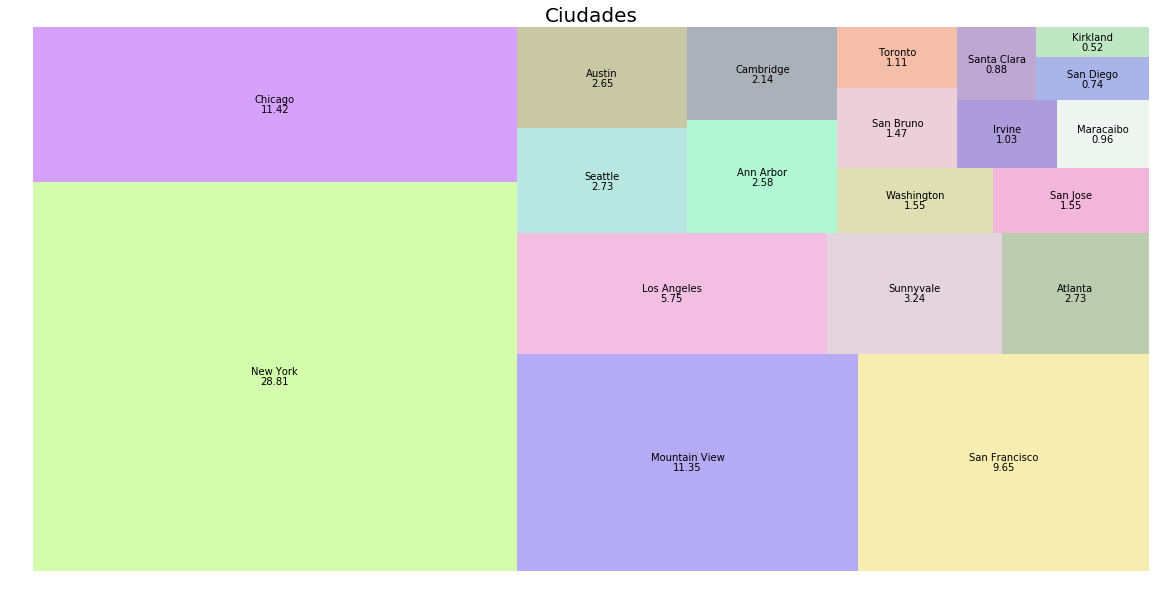

In [89]:
ciudades = round((city_squareBox["city"].value_counts()[:20] \
                       / len(city_squareBox['city']) * 100),2)

plt.figure(figsize=(20,10))
g = squarify.plot(sizes=ciudades.values, label=ciudades.index, 
                  value=ciudades.values,
                  alpha=.4, color=color)
g.set_title("Ciudades",fontsize=20)
g.set_axis_off()
plt.show()

# 
In this map we can easly see the city from where are done the high value transictions so, this map could be really usefull in input for the decisions of Supply Chain.
From this map are clear (considering only the visitors that have the location visible) the 3 city with the higher number of high value transactions:
- 28,8% of the big purchasing came from New York 
- 11,42% from Chicago 
- 11,35% form Montain View

Now that we can go on analysing the customer that are 

# 3. Análisis de los datos

## 3.1 Localización (Subcontinent, Country, City)

En esta sección se hablará de datos referentes a la localización del cliente. Para empezar, vamos a analizar datos de los subcontinentes para ver cuál es el que genera el mayor número de visitas. Seguido de paises y ciudades. A partir de los datos, analizaremos la relación que tienen estos con la variable objetivo, "totalTransactionRevenue".

### Análisis general de localización

In [24]:
#Veámos qué 15 países son los que mas aparecen en nustros datos. 
df1['subContinent'].value_counts()[:10]

Northern America    768345
Southeast Asia      121634
Southern Asia       121062
Western Europe      115153
Northern Europe     111693
Eastern Asia         91072
South America        75112
Eastern Europe       74007
Southern Europe      67184
Western Asia         60966
Name: subContinent, dtype: int64

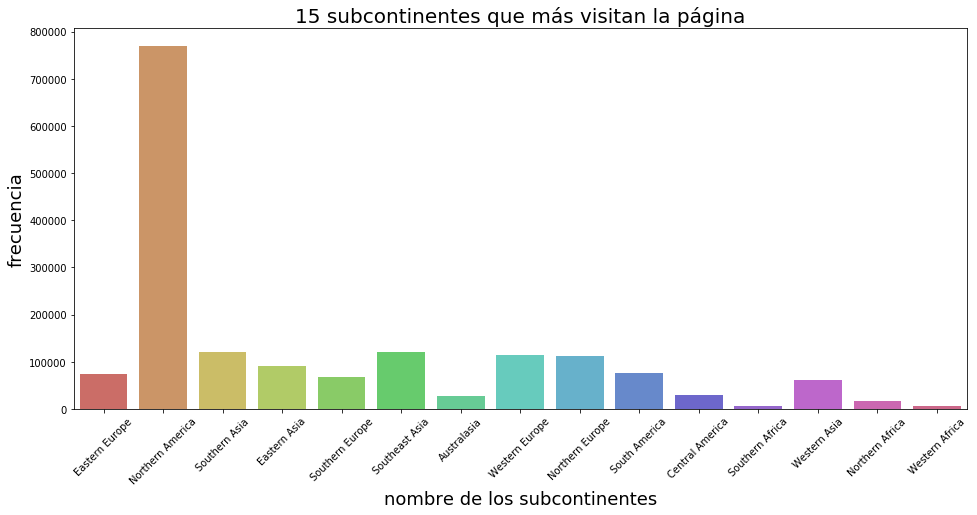

In [25]:
plt.figure(figsize=(16,7))    #SLIDE

# Histograma para los subcontinentes
sns.countplot(df1[df1['subContinent']\
                       .isin(df1['subContinent']\
                             .value_counts()[:15].index.values)]['subContinent'], palette="hls") # It's a module to count the category's
plt.title("15 subcontinentes que más visitan la página", fontsize=20) 
plt.xlabel("nombre de los subcontinentes", fontsize=18) 
plt.ylabel("frecuencia", fontsize=18) 
plt.xticks(rotation=45)

plt.show()    #SLIDE

Una vez visto el resultado del norte de América, veámos qué pais norteamericáno es que lidera en visitas. Aquí tendríamos que decidir entre analizar los clientes norteamericanos y quitar datos que se encuentren como outliers. 

In [26]:
df1['country'].value_counts(normalize=True)[:5]

United States     0.419833
India             0.061649
United Kingdom    0.042931
Canada            0.029887
Germany           0.022546
Name: country, dtype: float64

Definitivamente, el páis que más visitas realiza en la tienda es Estados Unidos con un total de 42% del total. 

In [27]:
#Aqui ignoramos los dos valores que hay en la variable ciudad.
city_squareBox = df1[df1.city != "(not set)"]
city_squareBox = city_squareBox[city_squareBox.city != "not available in demo dataset"]

In [28]:
numero_colores = 50 
# esto será capaz de generar muchos colores desde valores hexadecimales
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(numero_colores)]

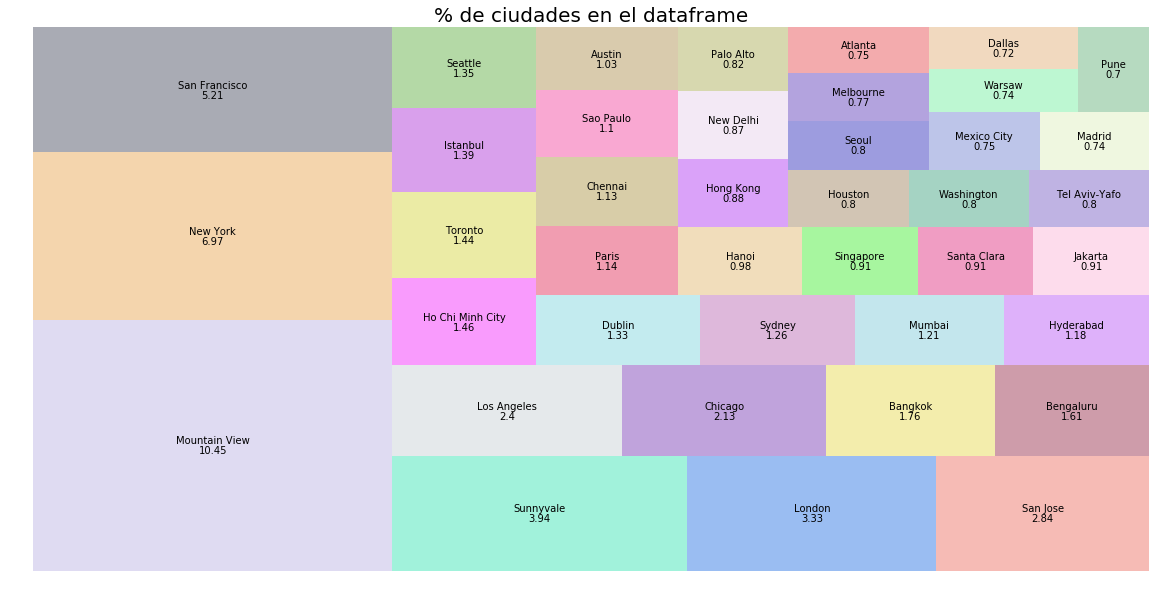

In [29]:
%matplotlib inline

#generamos un mapa de cuadros con el porcentaje de visitas de cada ciudad
ciudades = round((city_squareBox["city"].value_counts()[:40] \
                       / len(city_squareBox['city']) * 100),2)
plt.figure(figsize=(20,10))
g = squarify.plot(sizes=ciudades.values, label=ciudades.index, 
                  value=ciudades.values,
                  alpha=.4, color=color)
g.set_title("% de ciudades en el dataframe",fontsize=20)
g.set_axis_off()
plt.show()

### Análisis de localización con totalTransactionRevenue


Una vez averiguado desde qué locaclización se obtinene el mayor numero de visitas, veamos qué relevancia tienen esas visitas si lo analizamos conjuntamente con la variable que nos interesa, "totalTransactionRevenue"

In [30]:
py.init_notebook_mode(connected=True)

def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

A continuación veremos histogramas de "subContinent", "country" y "city" y en cada una de ellas veremo un conteo en las figuras de la parte izquierda y el valor medio de ingresos generados en la tienda. 

### La siguiente gráfica será generada con www.plot.ly

In [31]:

# aqui imprimimos el browser y lo analizamos en conjunto con transactionRevenue
cnt_srs = df1.groupby('subContinent')['totalTransactionRevenue'].agg(['size', 'mean'])
cnt_srs.columns = ["count", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), color="#FFDA4C")
trace2 = horizontal_bar_chart(cnt_srs["mean"].head(10), color="#FFDA4C")

# aqui imprimirmos la categoria de desktop, tablet o mobil y hacemos un cruce con trasactionRevenue. 
cnt_srs = df1.groupby('country')['totalTransactionRevenue'].agg(['size', 'mean'])
cnt_srs.columns = ["count", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace3 = horizontal_bar_chart(cnt_srs["count"].head(15), color="#3D79AA")
trace4 = horizontal_bar_chart(cnt_srs["mean"].head(15), color="#3D79AA")

# Hacemos un conteo de OS y lo cruzamos con transactionRevenue.
cnt_srs = df1.groupby('city')['totalTransactionRevenue'].agg(['size', 'mean'])
cnt_srs.columns = ["count", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace5 = horizontal_bar_chart(cnt_srs["count"].head(10), color="#F37727")
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10),color="#F37727")

fig = tools.make_subplots(rows=3, cols=2, vertical_spacing=0.04, 
                          subplot_titles=["Conteo - Subcontinentes", "Ganancia media - Subcontinentes",
                                          "Conteo - Países", "Ganancia media - Países", 
                                          "Conteo - Ciudades",  "Ganancia media - Ciudades"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace5, 3, 1)
fig.append_trace(trace6, 3, 2)

fig['layout'].update(height=1000, width=950, paper_bgcolor='rgb(255,255,255)', title="Histogramas de Regiones con outliers")
py.iplot(fig, filename='device-plots')


This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]



In [32]:
df_country_revenue = df1[df1['totalTransactionRevenue']> 0]
tmp = df_country_revenue['country'].value_counts()
country_revenue = pd.DataFrame(data={'country': tmp.values}, index=tmp.index).reset_index()
country_revenue.columns = ['Country', 'totalTransactionRevenue']

In [33]:
scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

def plot_country_map(data, location, z, legend, title, colormap='Rainbow'):
    data = dict(type = 'choropleth', 
                colorscale = scl,
                autocolorscale = False,
                reversescale = False,
               locations = data[location],
               locationmode = 'country names',
               z = data[z], 
               text = data[z],
               colorbar = {'title':legend})
    layout = dict(title = title, 
                 geo = dict(showframe = False, 
                         projection = {'type': 'natural earth'}))
    choromap = go.Figure(data = [data], layout=layout)
    py.iplot(choromap)

### La siguiente gráfica será generada con www.plot.ly

In [34]:
plot_country_map(country_revenue, 'Country', 'totalTransactionRevenue', 'Ingresos', 'Ingresos por país')

En la gráfica anterior vemos que, a nivel global, Estados unidos es el que más compras realiza en la tienda de Google. 

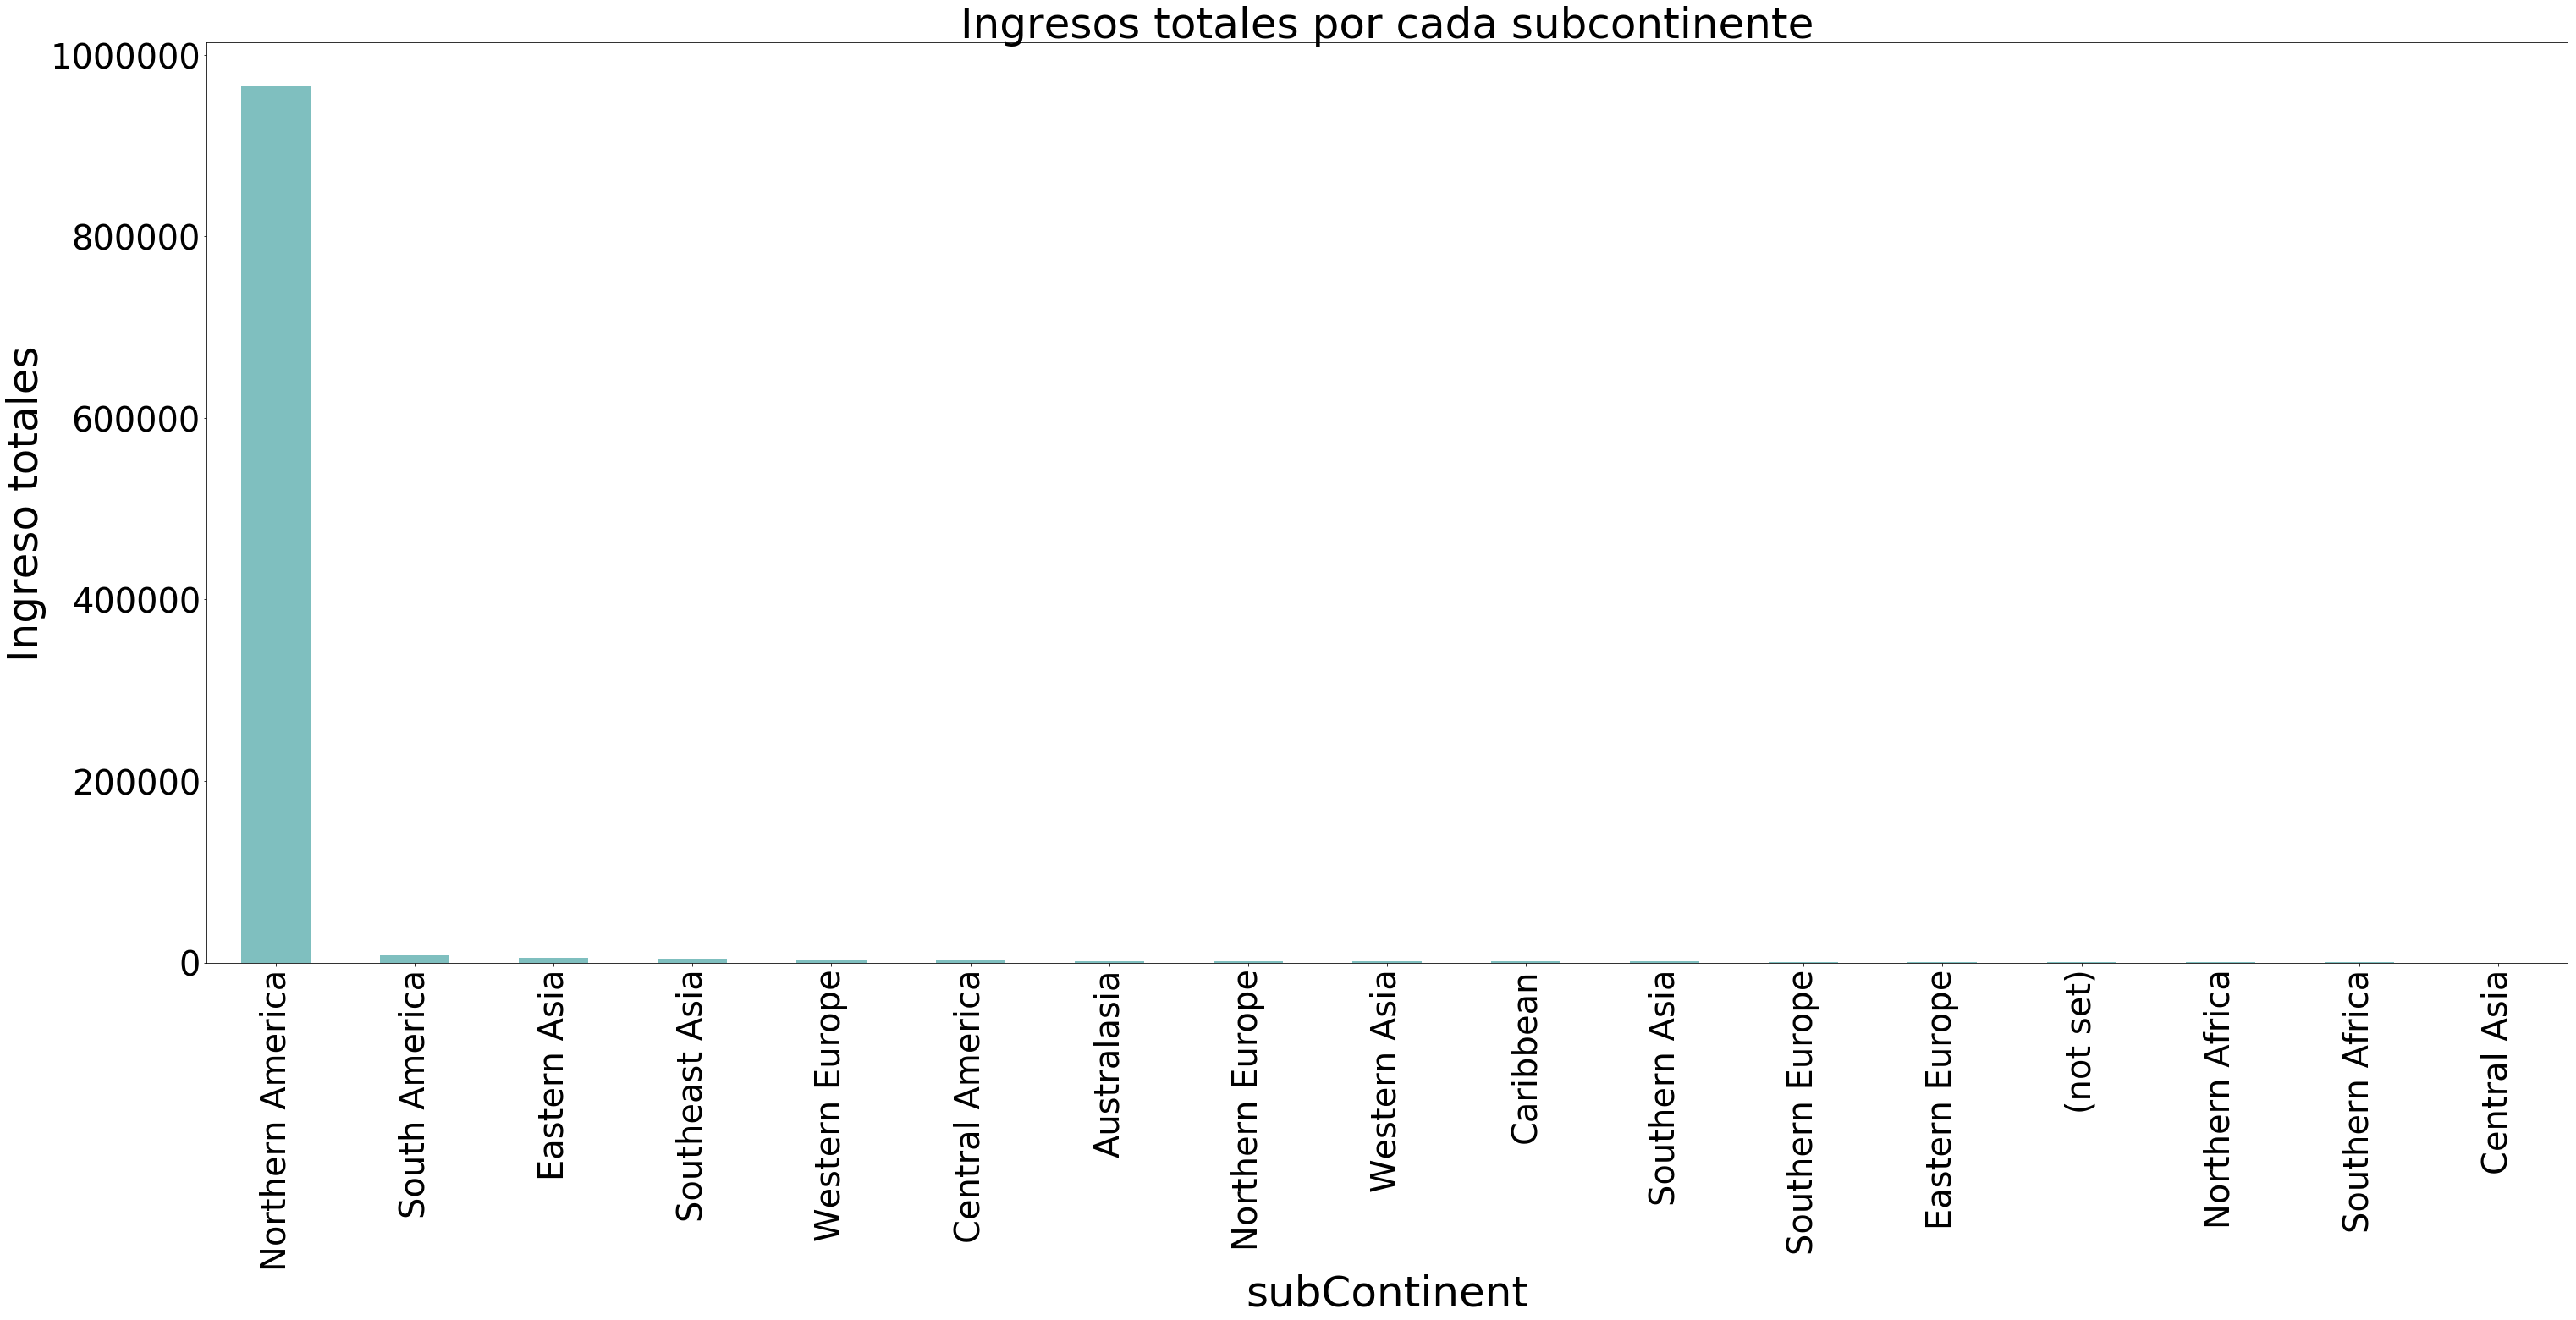

In [35]:
group = purchases['totalTransactionRevenue'].groupby(purchases['subContinent'])
average_salary = group.sum().sort_values(ascending=False)

plt.title("Ingresos totales por cada subcontinente", fontsize=50) 
plt.xlabel("nombre de los subcontinentes", fontsize=50) 
plt.ylabel("Ingreso totales", fontsize=50) 
plt.xticks(rotation=45, fontsize=40)
plt.yticks(fontsize=40)

average_salary.plot(kind='bar', figsize=(50, 20), color='teal', alpha=0.5);   #SLIDE

In [36]:
#Porcentaje de compras de Norte America
purchases[purchases['subContinent']=="Northern America"]['totalTransactionRevenue'].sum()/purchases['totalTransactionRevenue'].sum()

0.9681937411526922

In [37]:
#Porcentaje de compras de Sudamérica
purchases[purchases['subContinent']=="South America"]['totalTransactionRevenue'].sum()/purchases['totalTransactionRevenue'].sum()

0.008025979269245285

In [38]:
#Porcentaje de compras de Asia del Este
purchases[purchases['subContinent']=="Eastern Asia"]['totalTransactionRevenue'].sum()/purchases['totalTransactionRevenue'].sum()

0.005129481329907881

**Observación**:   #SLIDE
    
    El 96% de losingresos obtenidos de la tienda provienen de Norte América.

In [39]:
#Aqui ignoramos los dos valores que hay en la variable ciudad.
city_squareBox = purchases[purchases.city != "(not set)"]
city_squareBox = city_squareBox[city_squareBox.city != "not available in demo dataset"]

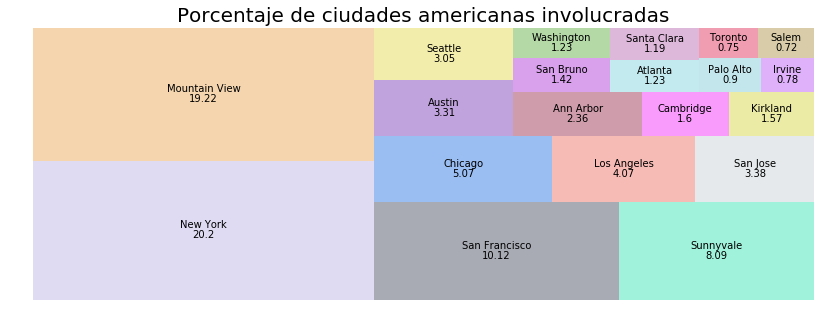

In [40]:
ciudades = round((city_squareBox["city"].value_counts()[:20] \
                       / len(city_squareBox['city']) * 100),2)

plt.figure(figsize=(14,5))
g = squarify.plot(sizes=ciudades.values, label=ciudades.index, 
                  value=ciudades.values,
                  alpha=.4, color=color)
g.set_title("Porcentaje de ciudades americanas involucradas",fontsize=20)
g.set_axis_off()
plt.show()


**Observación**:
    
    El 60% de las compras provienen de las cuatro ciudades estadounidenses que realizan la mayoría de las compras. 
    
       - Nueva York: 20,2%
       - Mountain Viwe: 19.22%
       - San fransisco: 10.12%
       - Sunnyvale 8.09%

# 3.2 Device (deviceCategory, operatingSystem)

En esta sección vamos a analizar el atributo "device". En esta parte veremos a través de qué dispositivo, el cliente visita la tienda y efectúa compras en ella. Veremos en qué tipo de dispositivos se siente más cómodo a la hora de realizar una compra pequeña o una con un precio elevado. 




### Análisis general de deviceCategory

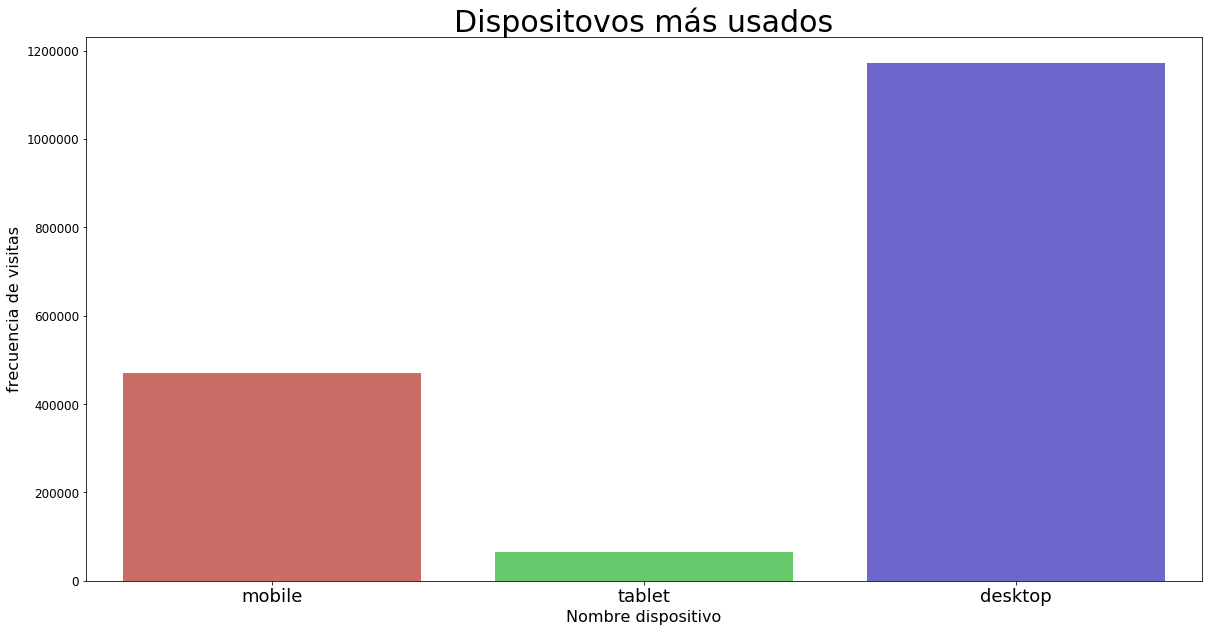

In [41]:
plt.figure(figsize=(20,10))  #SLIDE
sns.countplot(df1[df1['deviceCategory'].isin(df1['deviceCategory']
                                                       .value_counts()[:3].index.values)]['deviceCategory'], palette="hls") 
plt.title("Dispositovos más usados", fontsize=30) 
plt.xlabel("Nombre dispositivo", fontsize=16)  
plt.ylabel("frecuencia de visitas", fontsize=16) 
plt.xticks(fontsize=18)
plt.yticks(fontsize=12)
plt.show() 

En la gráfica anterior vemos que plataforma el cliente usa para visitar la tienda. Más interesante es saber en qué plataforma el cliente realiza más compras. Es común pensar que, por norma general, nos sentimos más cómodos realizando compras a través de una plataforma de mesa como es el caso de "desktop".

### Análisis de deviceCategory con totalTransactionRevenue

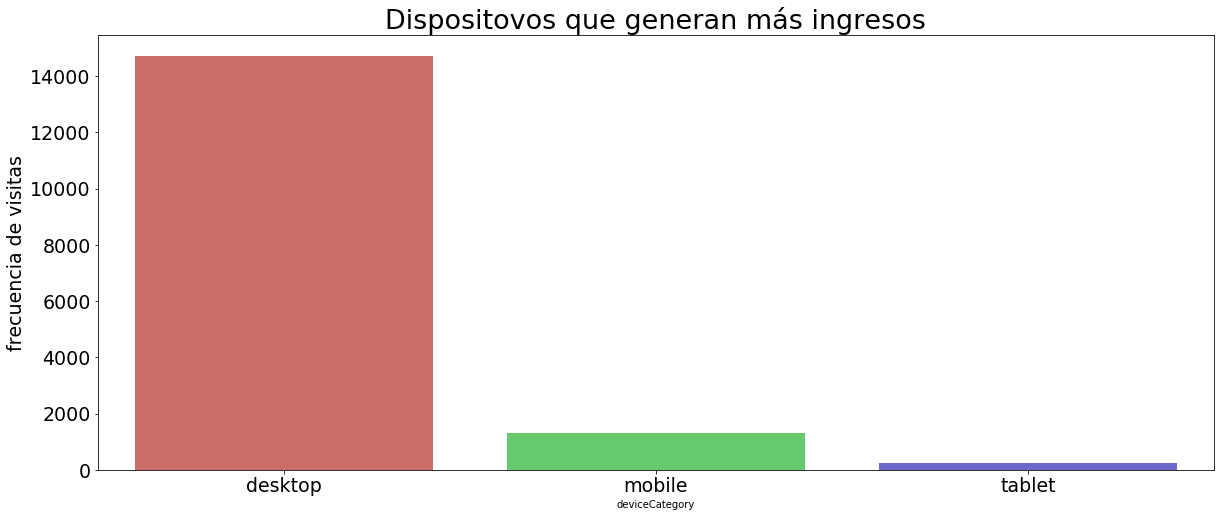

In [42]:
plt.figure(figsize=(20,8))  #SLIDE
sns.countplot(purchases[purchases['deviceCategory'].isin(purchases['deviceCategory']
                                                       .value_counts()[:3].index.values)]['deviceCategory'], palette="hls") 
plt.title("Dispositovos que generan más ingresos", fontsize=27) 

plt.ylabel("frecuencia de visitas", fontsize=19) 
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.show() 


**Observation**:

La gente que usa tablet y móvil realizan menos compras en la tienda. Puede ser una señal de que la tienda no deposita toda la confianza a través de la interfaz de esos dos dispositivos. 

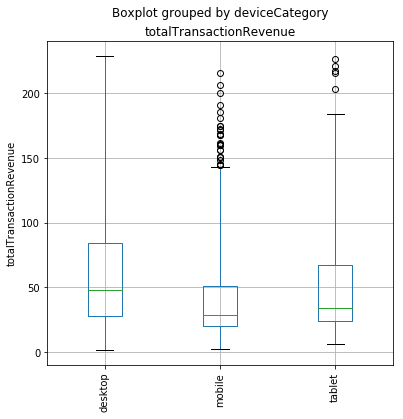

<Figure size 1080x504 with 0 Axes>

In [43]:
ax=purchases[['totalTransactionRevenue','deviceCategory']].boxplot( by='deviceCategory', figsize=(6, 6), rot=90, whis=3);

ax.set_xlabel('');
ax.set_ylabel('totalTransactionRevenue');
plt.figure(figsize=(15,7))

ax.set_title('totalTransactionRevenue');

From this graph we could se that by desktop people purchase product of a higher value, in mean and higher value, and the mobile for product of a lower price. 
This is really important, because could be used during the marketing planning to decide with which type of campaing or channer promote a product. 
For higher price product I would choice a channer/campaign that hase a high efficacy for the desktop

**Observation**: 
Customer buy higher price product by desktop and lower price by mobile (information about the client)

In [44]:
# 'P' es un array que guarda la probabilidad de que un visitante
# por cada dispositivo. 
P=[]
c=df1[df1['deviceCategory']=="desktop"].isBuy.value_counts()
P.append(float(c.iloc[1])/float(c.iloc[0])*100)

m=df1[df1['deviceCategory']=="mobile"].isBuy.value_counts()
P.append(float(m.iloc[1])/float(m.iloc[0])*100)

t=df1[df1['deviceCategory']=="tablet"].isBuy.value_counts()
P.append(float(t.iloc[1])/float(t.iloc[0])*100)
P

[1.464049593218519, 0.2902300562586707, 0.3758994737407368]

Aqui vemos la probablidad de que un usuario que visita la tienda, termine realizando una compra desde los distintos dispositivos. 

    - desktop: 1,46%
    - mobile: 0,29%
    - tablet: 0,376%
    
Aunque se realizan menos visitas desde tablet que desde móvil, la probabilidad de que una visita desde tablet es mayor que la de móvil.

In [45]:
'''
Aqui los que vamos a ver es el valor por cada visita obtenido multiplicando
la probabilidad obtenida antes en el array 'P[]' por la media de 
'totalTransactionRevenue' por cada dispositivo. 
'''

Value_each_visit=[]
Value_each_visit.append(float(P[0])*purchases[purchases['deviceCategory']=='desktop'].totalTransactionRevenue.mean()/100)
Value_each_visit.append(float(P[1])*purchases[purchases['deviceCategory']=='mobile'].totalTransactionRevenue.mean()/100)
Value_each_visit.append(float(P[2])*purchases[purchases['deviceCategory']=='tablet'].totalTransactionRevenue.mean()/100)

Value_each_visit


[0.9243170756950445, 0.1204009449003607, 0.19695331897123583]

#### Observación:
 #SLIDE
Obtenemos el valor medio en USD de cada visita en la tienda. 

- desktop price 0,90 USD por visita
- mobile price 0,12 USD por visita
- tablet price 0,20 USD por visita

Estos valores son muy útiles para la definición del presupuesto en el proceso de marketing. Un usuario "desktop" tiene un valor mucho mayor que uno de "mobile" o "tablet".



### Análisis general de operatingSystem

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

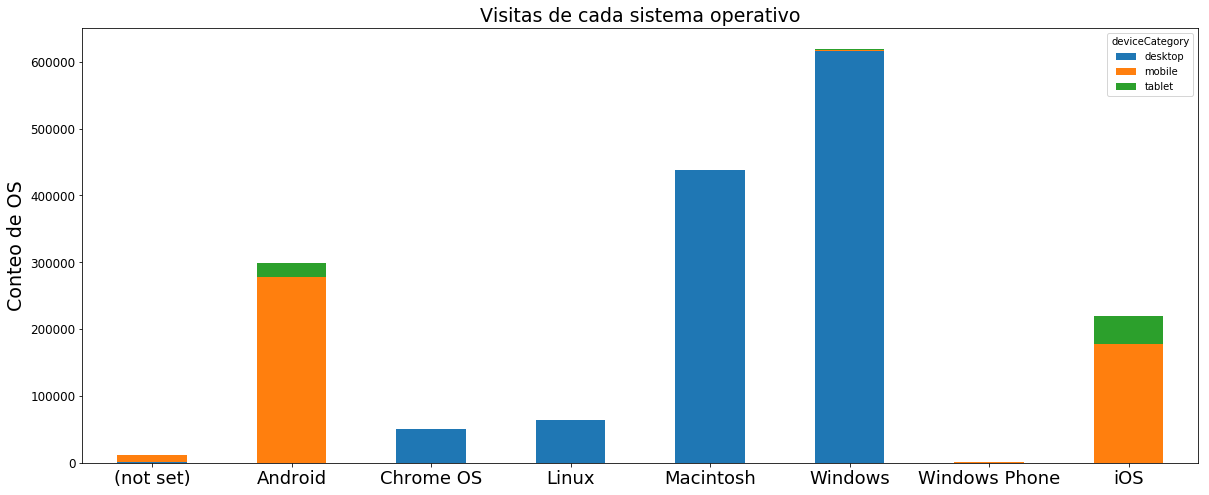

In [91]:
 #SLIDE
crosstab_eda = pd.crosstab(index=df1[df1['operatingSystem']\
                                          .isin(df1['operatingSystem']\
                                                .value_counts()[:8].index.values)]['operatingSystem'], 
                           
                           
                           columns=df1[df1['deviceCategory'].isin(df1['deviceCategory']\
                                                                            .value_counts()[:3].index.values)]['deviceCategory'])

crosstab_eda.plot(kind="bar",    
                 figsize=(20,8), # ajustando el tamaño de la gráfica
                 stacked=True)    
plt.title("Visitas de cada sistema operativo", fontsize=19) # ajustando el título y el tamaño de la fuente
plt.ylabel("Conteo de OS", fontsize=19) 
plt.xlabel("")
plt.xticks(fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(rotation=0) 


En la gráfica anterior vemos que los usuarios que más visitan la tienda lo hacen a través de un sistemaopertivo Windows y que la gran mayoria lo hace desde un dispositivo como puede ser un ordenador de mensa o portátil. 
    
    - Windows
    - Macintosh
    - Android

### Análisis de operatingSystem con totalTransactionRevenue

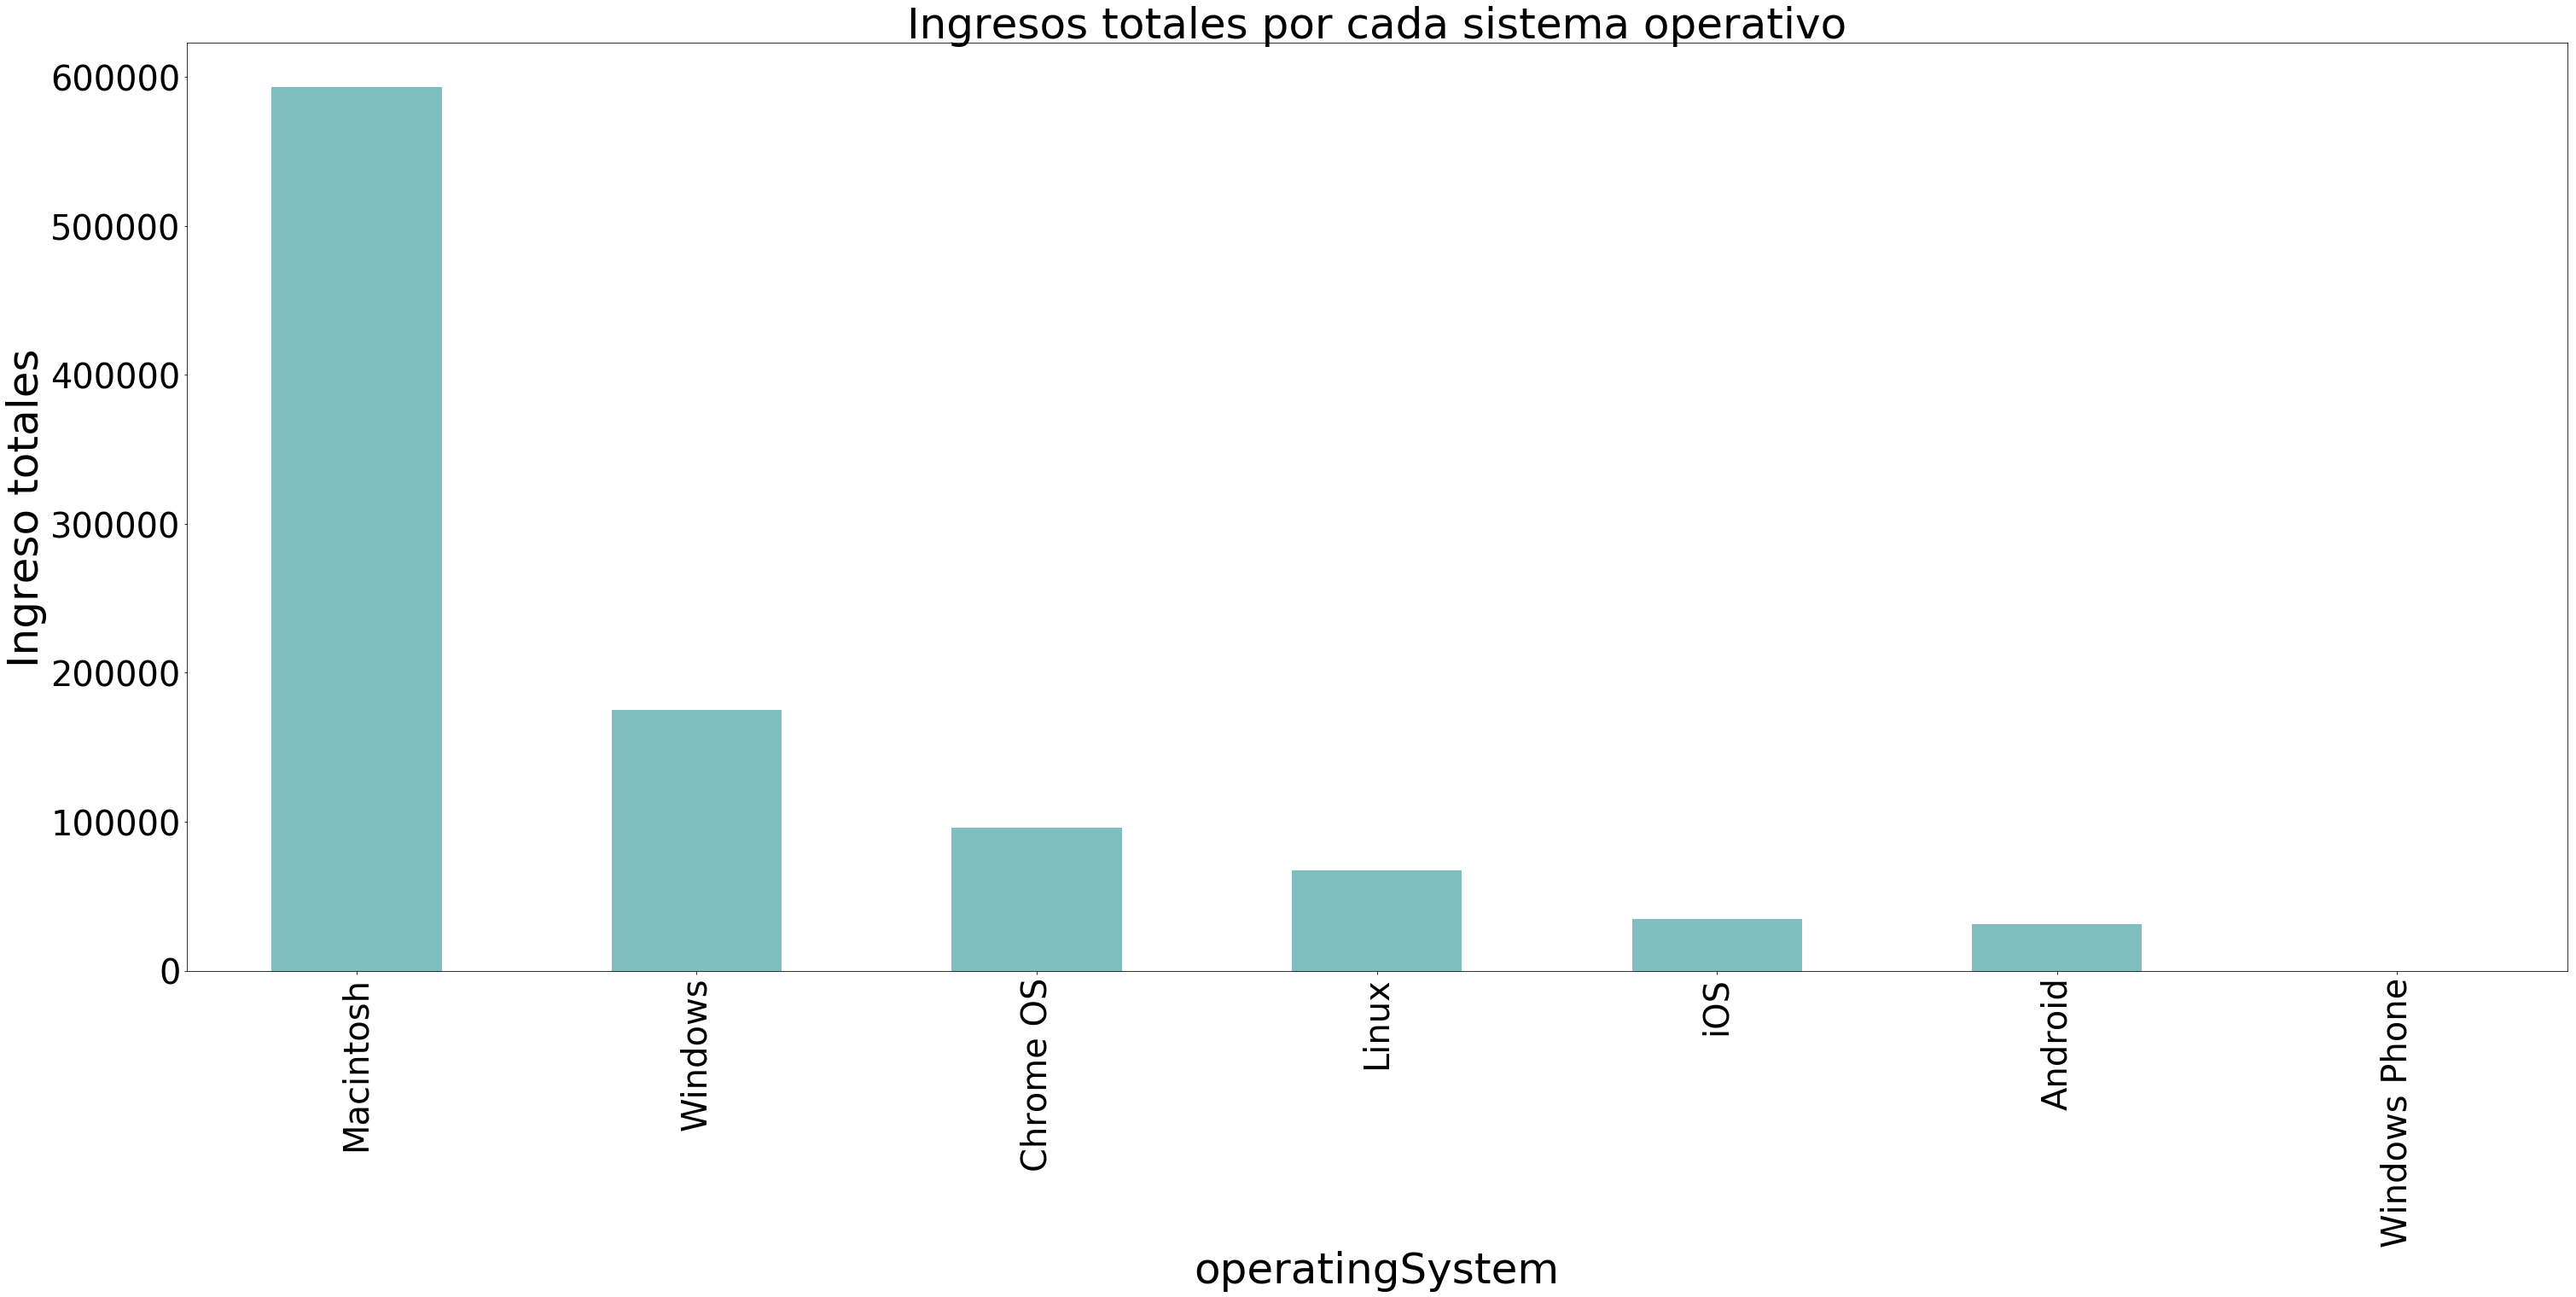

In [93]:


group = purchases['totalTransactionRevenue'].groupby(purchases['operatingSystem'])
average_salary = group.sum().sort_values(ascending=False)

plt.title("Ingresos totales por cada sistema operativo", fontsize=50) 
plt.xlabel("nombre de los sistema operativo", fontsize=50) 
plt.ylabel("Ingreso totales", fontsize=50) 
plt.xticks(rotation=45, fontsize=40)
plt.yticks(fontsize=40)

average_salary.plot(kind='bar', figsize=(50, 20), color='teal', alpha=0.5);   #SLIDE

A pesar que los usuarios de Windoews sean lso que más visitan han generado a lo largo de los dos años, cuando comprobamos si esas visitas significan algo para las ventas, comprobamos que Macintosh es el sistema operativo que genera el mayor numero deingresos en la tienda.

### Observación: 

Gran parte de los ingresos de la empresa proviene de los usuarios de Macintosh

In [48]:
P=[] # guardamos la probabilidad 

c=df1[df1['operatingSystem']=="Macintosh"].isBuy.value_counts()
P.append(float(c.iloc[1])/float(c.iloc[0])*100)

m=df1[df1['operatingSystem']=="Windows"].isBuy.value_counts()
P.append(float(m.iloc[1])/float(m.iloc[0])*100)

t=df1[df1['operatingSystem']=="Android"].isBuy.value_counts()
P.append(float(t.iloc[1])/float(t.iloc[0])*100)
t=df1[df1['operatingSystem']=="Chrome OS"].isBuy.value_counts()
P.append(float(t.iloc[1])/float(t.iloc[0])*100)

P

[2.4182548579970105,
 0.5795676045891497,
 0.25214895875539545,
 3.432429708757432]

 #SLIDE
Probabilidad de que un vistitante realice un compra categorizado por estos cuatro sistemas operativos. 

    1.   Macintosh purchases 2,42%  
    2.   Windows 0,58%
    3.   Android 0,25%
    4.   Chrome OS 3,43%
    
La probabilidad de compra de los "Macintosh" y "Chrome OS" son muchos más altos que los otros. 

In [49]:
#Calculamos el valor que tienen estos sistema operativo por cada visita
Value_each_visit=[]
Value_each_visit.append(float(P[0])*purchases[purchases['operatingSystem']=="Macintosh"].totalTransactionRevenue.mean()/100)
Value_each_visit.append(float(P[1])*purchases[purchases['operatingSystem']=="Windows"].totalTransactionRevenue.mean()/100)
Value_each_visit.append(float(P[2])*purchases[purchases['operatingSystem']=="Android"].totalTransactionRevenue.mean()/100)
Value_each_visit.append(float(P[3])*purchases[purchases['operatingSystem']=="Chrome OS"].totalTransactionRevenue.mean()/100)

Value_each_visit

[1.5957436713465274, 0.325396324512165, 0.11038705496032339, 2.38627509141169]

#### Observaciones:  #SLIDE
Aquí calculamos el valor monetario medio que tiene la visita de cada sistema operativo. Estos son los resultados: 

    - Macintosh precio 1,60 USD by visit
    - Windows precio 0,33 USD by visit
    - Android precio 0,11 USD by visit 
    - Chrome Os precio 2,39 USD by visit
   


In [50]:
Q=[]
Q.append(purchases[purchases['operatingSystem']=="Macintosh"]['totalTransactionRevenue'].sum()/purchases['totalTransactionRevenue'].sum())
Q.append(purchases[purchases['operatingSystem']=="Windows"]['totalTransactionRevenue'].sum()/purchases['totalTransactionRevenue'].sum())
Q.append(purchases[purchases['operatingSystem']=="Chrome OS"]['totalTransactionRevenue'].sum()/purchases['totalTransactionRevenue'].sum())
Q

[0.594976221194921, 0.17542591833331456, 0.09630297445079299]

Aqui podemos ver las ganancias total hecha por cada sistema operativo. Vemos que el 60% del el total de los ingresos proviene de Macintosh seguido de 17% de Windows y 9% de Chrome OS. 

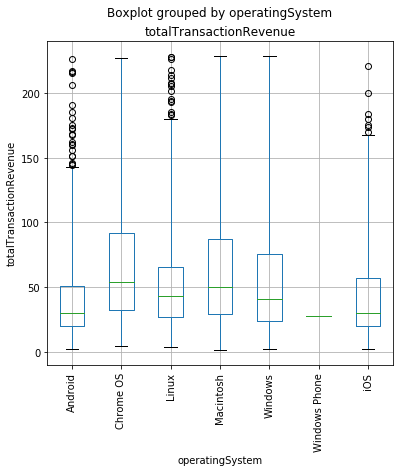

<Figure size 1080x504 with 0 Axes>

In [51]:
ax=purchases[['totalTransactionRevenue','operatingSystem']].boxplot( by='operatingSystem', figsize=(6, 6), rot=90, whis=3);
plt.figure(figsize=(15,7))

ax.set_xlabel('operatingSystem');
ax.set_ylabel('totalTransactionRevenue');
ax.set_title('totalTransactionRevenue');

Aqui vemos que entre los sistemas operativos, tenemos distintas mediana por cada uno. Tambié spodemos visualizar que las compras con más valor la tiene Macintosh, Chrome OS y Windows. 

# 3.3 ChannelGrouping

En esta sección vamos a ver desde qué medio el cliente ha accedido a la tienda. 

### Análisis general de channelGrouping

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

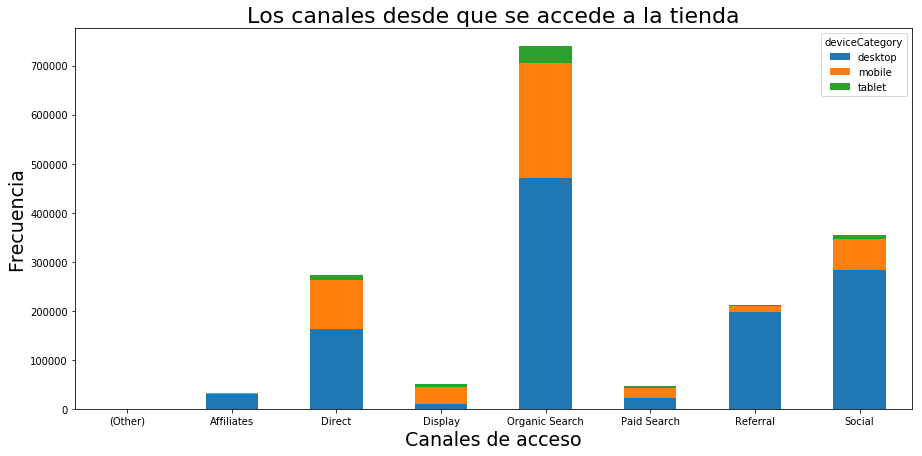

In [95]:
#SLIDE    
crosstab_eda = pd.crosstab(index=df1[df1['channelGrouping']\
                                          .isin(df1['channelGrouping']\
                                                .value_counts()[:8].index.values)]['channelGrouping'], 
                           
                           
                           columns=df1[df1['deviceCategory'].isin(df1['deviceCategory']\
                                                                            .value_counts()[:3].index.values)]['deviceCategory'])

crosstab_eda.plot(kind="bar",    
                 figsize=(15,7), 
                 stacked=True)  
plt.title("Los canales desde que se accede a la tienda", fontsize=22) 
plt.xlabel("Canales de acceso", fontsize=19) 
plt.ylabel("Frecuencia", fontsize=19) 
plt.xticks(rotation=0) 

### Análisis de channelGrouping con transactionRevenue

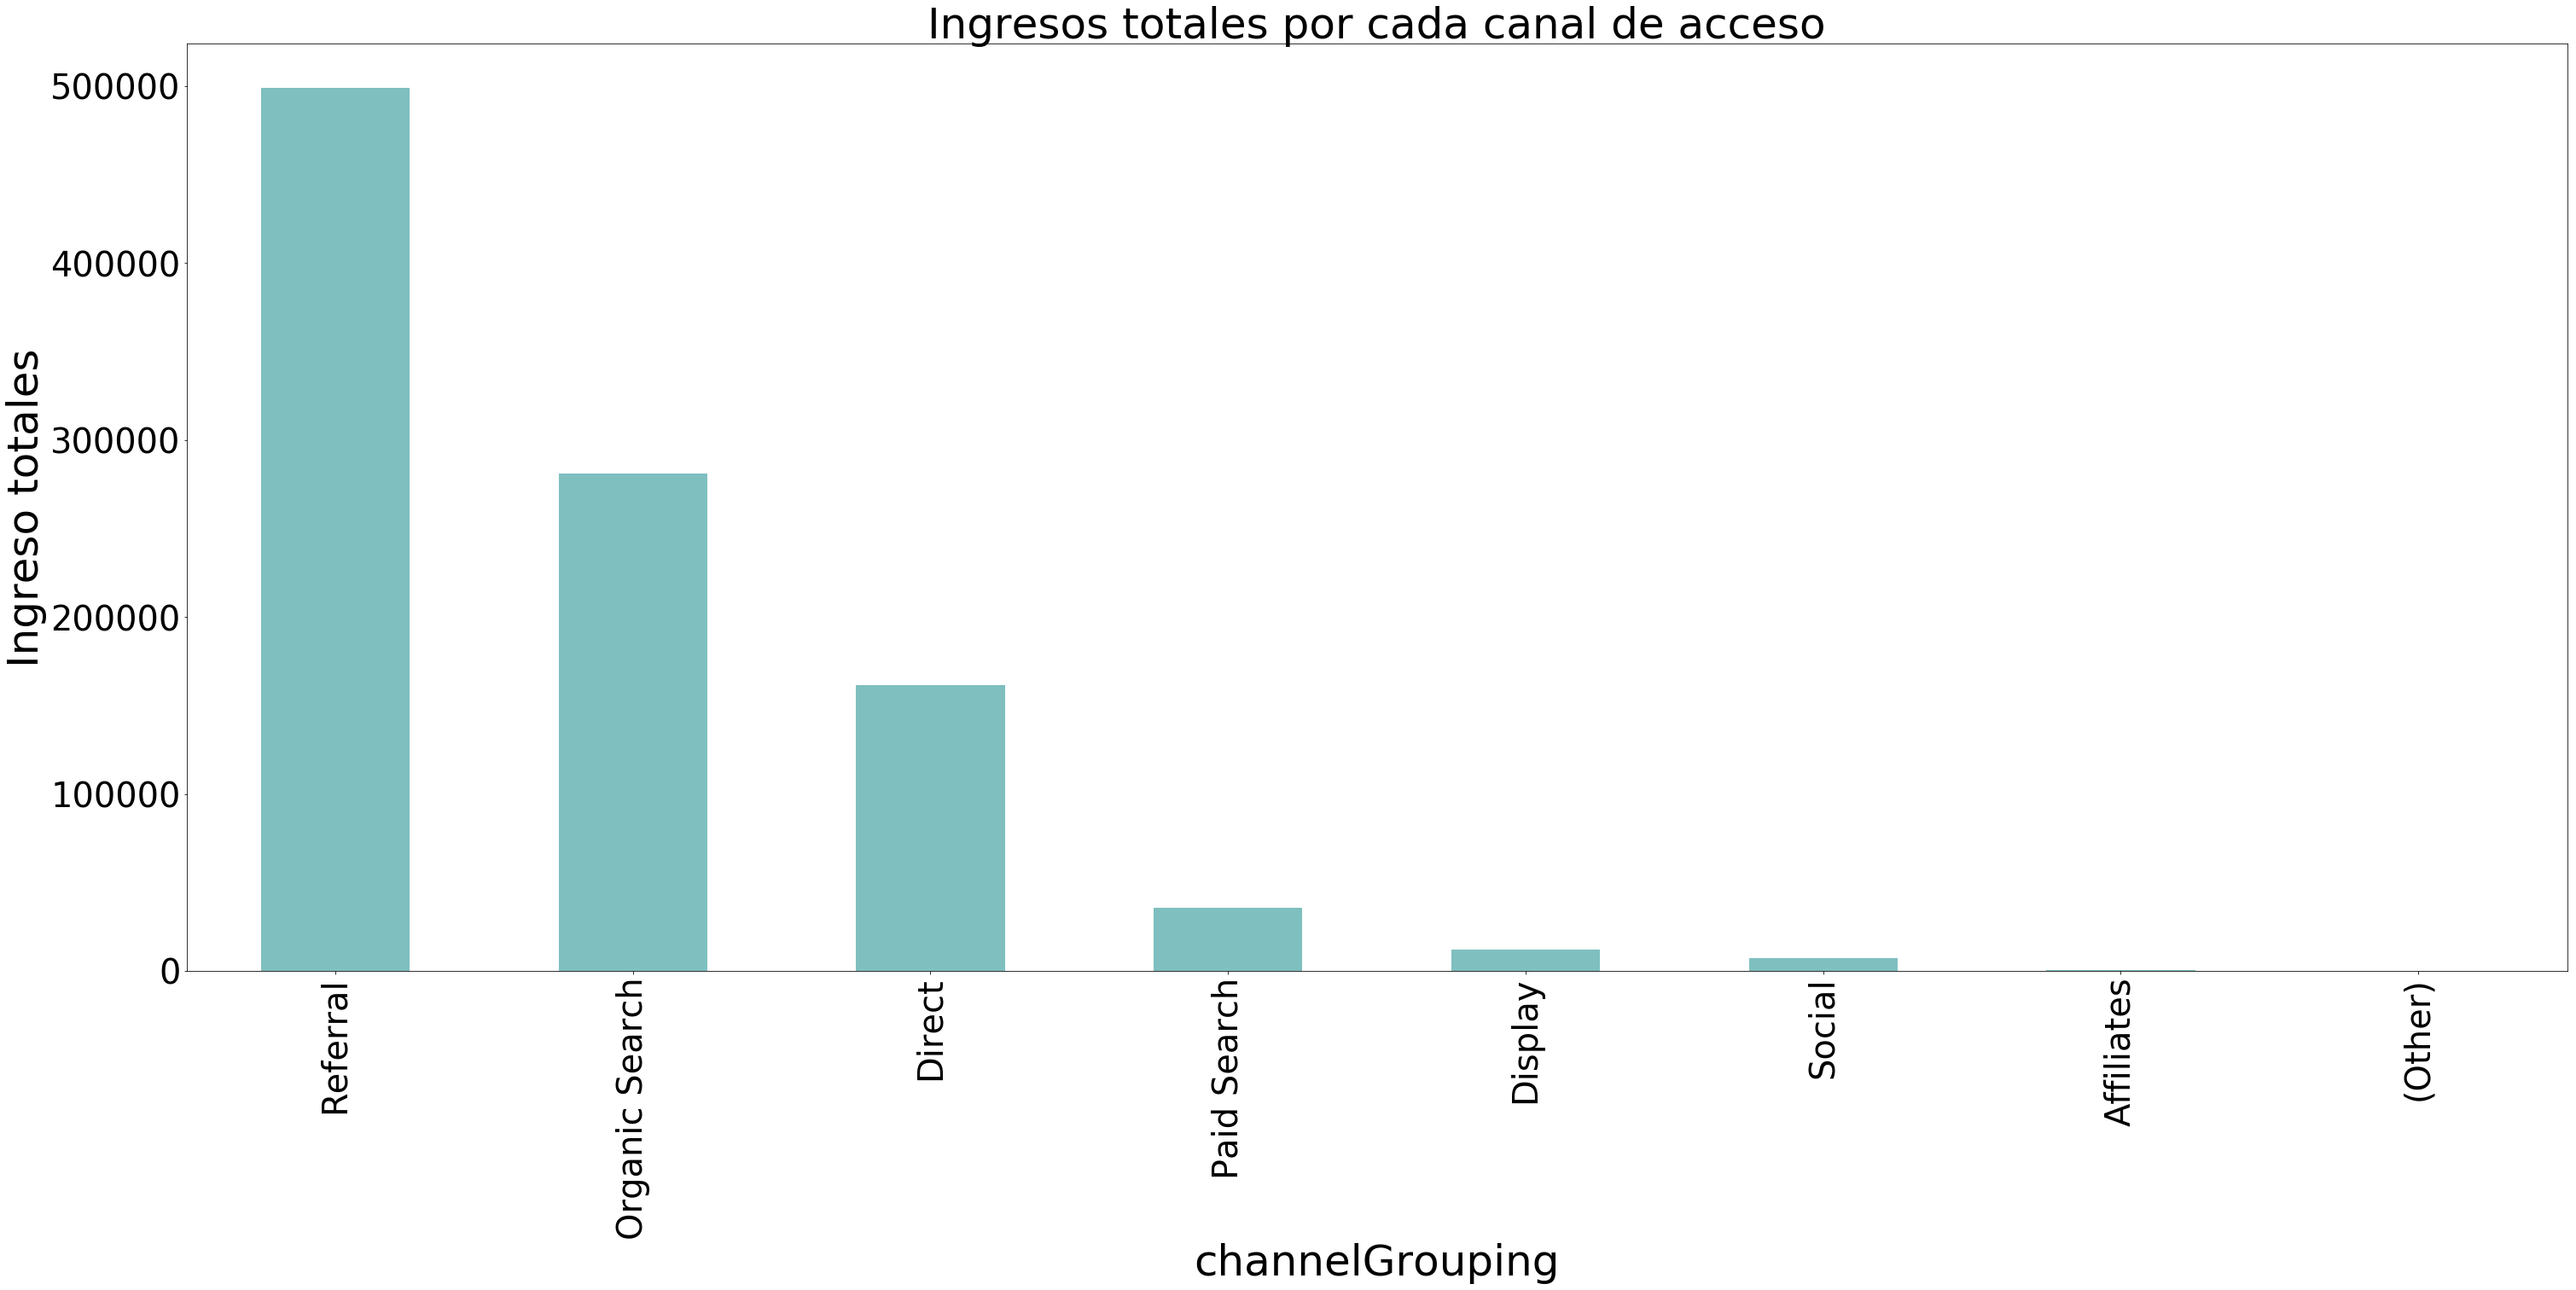

In [98]:
#la variable group es por cada subcontinente cogermos solo los que han comprado

group = purchases['totalTransactionRevenue'].groupby(purchases['channelGrouping'])
average_salary = group.sum().sort_values(ascending=False)

plt.title("Ingresos totales por cada canal de acceso", fontsize=50) 
plt.xlabel("nombre de los canal de acceso", fontsize=50) 
plt.ylabel("Ingreso totales", fontsize=50) 
plt.xticks( fontsize=40, rotation=45)
plt.yticks(fontsize=40,)

average_salary.plot(kind='bar', figsize=(50, 20), color='teal', alpha=0.5);   #SLIDE

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

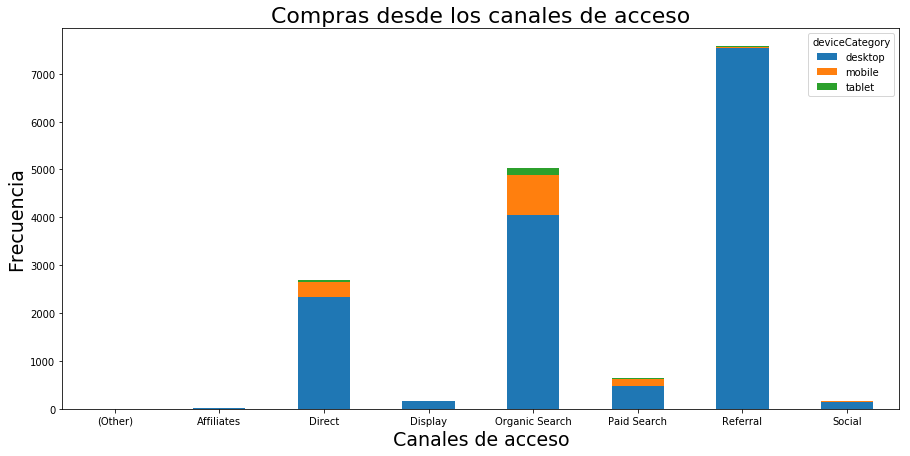

In [103]:
#SLIDE

crosstab_eda = pd.crosstab(index=purchases[purchases['channelGrouping']\
                                          .isin(purchases['channelGrouping']\
                                                .value_counts()[:8].index.values)]['channelGrouping'], 
                           
                           
                           columns=purchases[purchases['deviceCategory'].isin(purchases['deviceCategory']\
                                                                            .value_counts()[:3].index.values)]['deviceCategory'])

crosstab_eda.plot(kind="bar",    
                 figsize=(15,7), # adjusting the size of graphs
                 stacked=True)   # code to unstack 
plt.title("Compras desde los canales de acceso", fontsize=22) 
plt.xlabel("Canales de acceso", fontsize=19) 
plt.ylabel("Frecuencia", fontsize=19) 
plt.xticks(rotation=0) # Adjust the xticks, rotating the labels

Podemos ver entre ambas gráficas una diferencia en las frecuencias dado que la primera engloba a todos lso datos incluidos a los que no compran. En la segunda gráfica acotamos a aquellos clientes que si compran. 

### Observación:

Tras visualizar en grágico de frecuencias de todos los que visitna la tienda, vemos que los cananales más utilizados son "Organic Search", "Direct", "Social" y "Referral" respectivamente. Pero si vemos el segundo gráfico en el que tomamos en consideración solo los que compran, vemos que los clientes que utilizan el canal "Referral" es el que más ingresos genera en la tienda. Seguido por el canal "Organic Search" y "Direct". Entonces los visitantes que utilizan el canal "Referral" tienen una mayor probabilidad de realizar una compra. 




### Ingresos totales de desktop desde cada canal de acceso

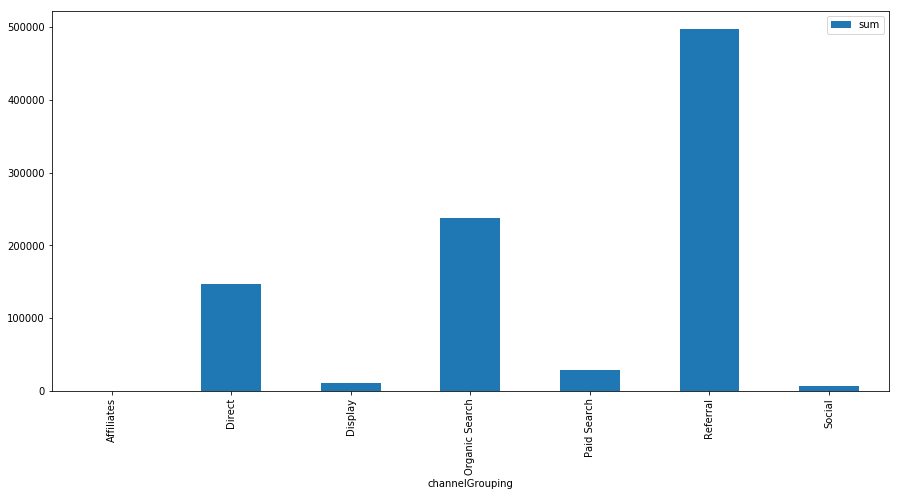

In [55]:
purchases[purchases['deviceCategory']=="desktop"].groupby('channelGrouping')['totalTransactionRevenue'].agg([np.sum]).plot(kind='bar',figsize=(15,7))


### Ingresos totales de mobile desde cada canal de acceso

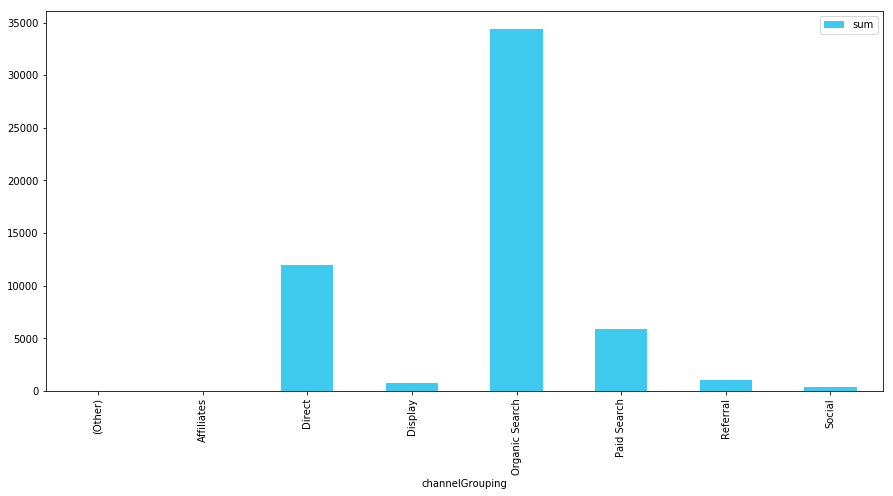

In [56]:
purchases[purchases['deviceCategory']=="mobile"].groupby('channelGrouping')['totalTransactionRevenue'].agg([np.sum]).plot(kind='bar', color='#3ECAEF',figsize=(15,7))


### Ingresos totales de desktop desde cada canal de acceso 

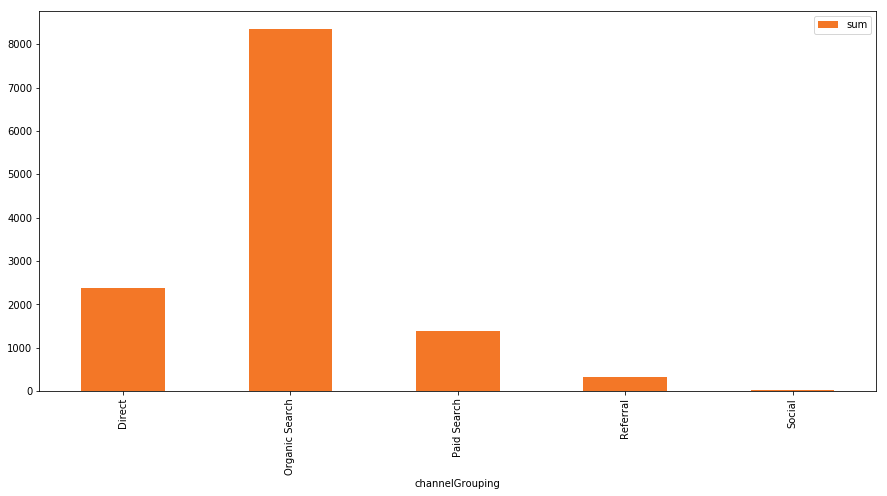

In [57]:
purchases[purchases['deviceCategory']=="tablet"].groupby('channelGrouping')['totalTransactionRevenue'].agg([np.sum]).plot(kind='bar', color='#F37727',figsize=(15,7))


### Observación:


De estos 3 graficos anteriores podemos observar que la frecuencia de uso de los caneles de un cliente varian dependiendo del dispositivo que se utilice. 

Obviamente la frecuencia en 'organic search' y en 'direct channel' tienen valores muy altos en los 3 tipos de dispositivos, esto se debe a que el usuario ya esta interesado en el producto. 

En desktop podemos ver que al contrario que en los otros dos dipositivos (tablet y mobile), hay un alto porcentaje de 'referral'. Lo que quiere decir que los usuarios que compraron desde desktop prefirieron usar el canal referral. Esta información puede ser muy útil para el departamento de marketing, esta información les prodría permitir reorganizar su estrategia respecro al marketing acerca de referral para tratar de mejorar los resultados en mobil y tablet.

# 3.4 TrafficSource (campaign)

Aqui vamos a ver que campaña realizadas en en canal "paid search" ha aportado más ventas. 


In [58]:
tabla=purchases.groupby(['channelGrouping','campaign'])['channelGrouping'].agg({'Frequency':'count'})
tabla[tabla['Frequency']>10]

/Users/mathias/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version



Frequency
channelGrouping campaign                                     
Affiliates      Data Share Promo                           15
Direct          (not set)                                2701
Display         (not set)                                 159
Organic Search  (not set)                                5034
Paid Search     (not set)                                 247
                AW - Accessories                          117
                AW - Dynamic Search Ads Whole Site        269
Referral        (not set)                                7571
Social          (not set)                                 154

In [59]:
AW_D=purchases[purchases['campaign']=="AW - Dynamic Search Ads Whole Site"]['totalTransactionRevenue'].sum()
AW_A=purchases[purchases['campaign']=="AW - Accessories"]['totalTransactionRevenue'].sum()
AW_D

14735.5

In [60]:
AW_A

6430.700000000001

In [61]:
(AW_A+AW_D)/purchases[purchases['channelGrouping']=="Paid Search"]['totalTransactionRevenue'].sum()



0.5945925902204123

### Observación:

Las únicas campañas realmente efectivas en el canal "paid search" son:

    - AW  Accessories con 6430 USD
    - AW  Dynamic Search Ads Whole Site con 14735,5 USD
    
 #SLIDE

Todas juntas vasn a componer el 62% del total de los ingresos aportados a través de "paid search".

In [62]:
purchases.groupby(['channelGrouping','adPosition'])['channelGrouping'].agg({'Frequency':'count'})

/Users/mathias/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version



Frequency
channelGrouping adPosition           
Display         RHS                 5
Paid Search     RHS                 4
                Top               585

Aqui vamos a analizar los rsultados por la distinta posición del canal "paid search".

In [63]:
purchases['adPosition'].value_counts()

Top    585
RHS      9
Name: adPosition, dtype: int64

In [64]:
purchases[purchases['adPosition']=='Top']["totalTransactionRevenue"].sum()


31941.850000000002

In [65]:
purchases[purchases['adPosition']=='RHS']["totalTransactionRevenue"].sum()


378.41999999999996

#### Observación:
De las ventas realizada a través del canal "paid search", obtenemos buenos resultados con la primera posición con 585 ventas y un ingreso de 


Of the sells made by paid search we obtained good results with the Top position, making 606 sells and a return of this strategy of 388837€.
In the other hand with the RHS we were able to obtaine only 11 sells with total profit of 943€. This one in particular is really low, we have to compare with the cost of this paid search for rethink a new strategy for increase the sells with this channel.


# 3.5 VisitStartTime 

En esta parte veremos los patrones que se pueden encontrar en cuanto a las franjas horarias. También combinaremos el horario y la fecha por separado en conjunto con "totalTransactionRevenue" y otros atributos para ver cuándo se genera más tráfico en la tienda.

### Análisis general de visitStartTime

In [66]:

# Separamos la fecha de la hora en dos columnas separadas. 
df1["visitStartTime"] = pd.to_datetime(df1["visitStartTime"],unit='s')
df1['date'] = [d.date() for d in df1['visitStartTime']]

print('Fecha inicio:', min(df1['date']), 'hasta', max(df1['date']))
 

Fecha inicio: 2016-08-01 hasta 2018-05-01


In [67]:
 #SLIDE

df_device = df1[df1['totalTransactionRevenue']> 0]

# code for removing outliers
Q1 = df_country_revenue['totalTransactionRevenue'].quantile(0.00)
Q3 = df_country_revenue['totalTransactionRevenue'].quantile(0.75)
IQR = Q3 - Q1
df_device = df_device[df_device['totalTransactionRevenue'] > (Q1-1.5*IQR)]
df_device = df_device[df_device['totalTransactionRevenue'] < (Q3+1.5*IQR)]

channels = list(df_device['deviceCategory'].unique()[:10])

data = []
for channel in channels:
    subset = df_device[df_device['deviceCategory']==channel]
    subset = subset.groupby('date')['totalTransactionRevenue'].agg(['sum'])
    subset.columns = ["Total"]
    subset = subset.sort_index()
    trace = go.Scatter(
        x = subset['Total'].index,
        y = subset['Total'].values,
        name=channel,
        mode='lines'
    )
    data.append(trace)
layout= go.Layout(
    title= 'Ingresos de la tienda por cada país',
    xaxis = dict(title = 'Date'), yaxis = dict(title = 'Total revenue'),
    showlegend=True,
)
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='lines')

En la gáfica anterior podemos ver la tendencia que se sigue los ingresos obtenidos por la tienda desde los diferentes dispositivos. Como la la mayoría de las comrpas se realizan en norteamérica, vemos que el desde el 24 de noviember hasta finales de diciembre, vemos que en ambos años se ve el resultado de: 

    - 24 de noviembre: Black Friday
    - 25 de noviembre: Thanksgiving Day
    - 27 de noviembre: Cyber Monday
    - 16 de diciembre: Free Shipping Day
    - 25 de dimiebre: Christmas





### Análisis de VisitStartTime con totalTransactionRevenue

En esta parte lo que haremos será analizar el comportamiento y los patrones al combinar la hora y la fecha con los ingresos obtenidos en la tienda. Anteriormente habíamos hecho transformaciones a la columda "VisitStartTime" separándola en otras 6 columnas en las que tenemos: 

    Time -  en formato hh:mm:ss
    day - En esta aparecen número del 1 al 31 que corresponde a la fecha en el mes
    month - Meses del año numerados del 1 al 12
    weekday - Dias de la semana numerados del 1 al 7 siendo 1 Lunes. 
    weekofyear - El número de la semana a lo largo del año. 
    hour - La hora correspondiente a la columna "time" empezando en 0 hasta el 23.
    date - La fecha en formato YYYY-mm-dd

Con estos datos los realizaremos los siguienets análisis. 

In [68]:
 #SLIDE

#Sacamos un mapa de calor para ver si encontramos patrones interesantes
axis = ['hour', 'weekday'] #[Y, X]

cm = sns.light_palette("#36729C", as_cmap=True)
pd.crosstab(df1[axis[0]], df1[axis[1]], 
            values=df1["totalTransactionRevenue"], aggfunc=[np.sum]).style.background_gradient(cmap = cm)

Hemos podido encontrar unos patrones entre las 15:00 y las 22:00 horas. Aparentemente es esta la franja horaria en la que más ingresos obtiene la tienda. A esta hora es la hora más habitual en la que muchos de los clientes están en casa o hayan finalizado su jornada laboral. Es importante apuntar que lo que hemos encontrado aqui corresponde a compras efectuadas por clientes de diversos países, con lo que la hora esta regulada por el UTC (Universal Coordinated Time) lo cual indica que en el sistema de almacenaje de datos, se ha recolectado la hora UTC para saber a qué hora el cliente accede a la tienda. Hay más informacion sobre UTC en el siguiente enlace: 

    https://en.wikipedia.org/wiki/Coordinated_Universal_Time
  

A continuación haremos lo mismo pero observando el comportamiento de manera mensual y no semanal. 

In [69]:
axis = ['hour', 'month'] #seting the desired 

cm = sns.light_palette("#F37727", as_cmap=True)
pd.crosstab(df1[axis[0]], df1[axis[1]], 
            values=df1["totalTransactionRevenue"], aggfunc=[np.sum]).style.background_gradient(cmap = cm)

Vemos que se obtiene los mismo patrones en ambas gráficas. En este podemo observar la concentración de compras que hay en los meses de 10-12 que correponden a epocas de Acción de Gracias como es el 22 de Noviembre en EEUU seguido por navidad. También es interesante destacar que a las 10 de la mañana del mes 7 (julio) no se han registrado ingresos. 




# 3.6 La regla del 20-80 




In [70]:
df1.head()

,channelGrouping,fullVisitorId,visitNumber,visitStartTime,browser,deviceCategory,operatingSystem,city,country,region,...,totalTransactionRevenue,transactions,date,time,day,month,weekday,weekofyear,hour,isBuy
0,Organic Search,3623819892424331961,1.0,2017-05-29 15:56:49,Chrome,mobile,Android,not available in demo dataset,Czechia,Czechia,...,0.0,NaN,2017-05-29,15:56:49,29,5,0,22,15,False
1,Organic Search,0538928163114544921,1.0,2017-05-29 16:07:23,Chrome,tablet,Android,not available in demo dataset,United States,United States,...,0.0,NaN,2017-05-29,16:07:23,29,5,0,22,16,False
2,Organic Search,5863936343673668667,2.0,2017-05-29 19:43:31,Chrome,desktop,Windows,Bengaluru,India,Karnataka,...,0.0,NaN,2017-05-29,19:43:31,29,5,0,22,19,False
3,Organic Search,9993197829693068679,9.0,2017-05-29 23:09:51,Safari,mobile,iOS,San Jose,United States,California,...,0.0,NaN,2017-05-29,23:09:51,29,5,0,22,23,False
4,Referral,0635666386021193101,13.0,2017-05-29 09:20:43,Chrome,desktop,Windows,Osaka,Japan,Osaka Prefecture,...,0.0,NaN,2017-05-29,09:20:43,29,5,0,22,9,False


In [71]:
analysis_data = df1.copy()
    
extract_date_info(analysis_data, 'month')
extract_date_info(analysis_data, 'weekday')
analysis_data.drop(['visitStartTime'], axis=1, inplace=True)

In [72]:
compras = analysis_data[analysis_data['totalTransactionRevenue'] > 0]

In [73]:
compras.head()

,channelGrouping,fullVisitorId,visitNumber,browser,deviceCategory,operatingSystem,city,country,region,subContinent,...,totalTransactionRevenue,transactions,date,time,day,month,weekday,weekofyear,hour,isBuy
9,Organic Search,4199946232412788468,1.0,Chrome,desktop,Windows,not available in demo dataset,United States,United States,Northern America,...,69.96,1,2017-05-30,04:20:15,30,5,1,22,4,True
23,Organic Search,3171569265705804808,2.0,Chrome,desktop,Chrome OS,not available in demo dataset,United States,United States,Northern America,...,31.82,1,2017-05-30,00:53:10,30,5,1,22,0,True
28,Direct,472971982753353098,1.0,Chrome,desktop,Linux,New York,United States,New York,Northern America,...,34.18,1,2017-05-29,19:09:52,29,5,0,22,19,True
32,Organic Search,4068234234266916182,2.0,Chrome,desktop,Macintosh,not available in demo dataset,Argentina,Argentina,South America,...,65.06,1,2017-05-29,13:41:19,29,5,0,22,13,True
43,Direct,4757786080947166229,3.0,Safari,mobile,iOS,not available in demo dataset,United States,United States,Northern America,...,34.79,1,2017-05-29,18:42:38,29,5,0,22,18,True


In [77]:

compras=df1[df1['totalTransactionRevenue']>0]
twentyPercentClients2 = int(compras.shape[0]*0.2)
twentyPercentClientsPurchases2 = compras['totalTransactionRevenue'].sort_values(ascending=False)[:twentyPercentClients2].sum()
total=compras['totalTransactionRevenue'].sum()


In [78]:
twentyPercentClientsPurchases2/total

0.7203093972166383

 #SLIDE

Podemos comprobar que más o menos se cumple la regla del 20-80 ya que el 20% de los clientes que realizan una compra generan el 72% de  nuestros ingresos totales 

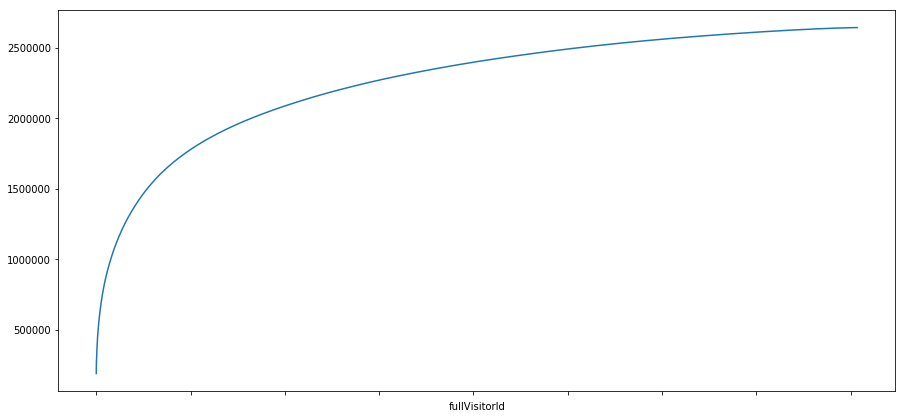

In [79]:
tmp=compras[['fullVisitorId','totalTransactionRevenue']]
tmp_grupped=tmp['totalTransactionRevenue'].groupby(tmp['fullVisitorId'] )
plt.figure(figsize=(15,7))


tmp_grupped.sum().sort_values(ascending=False).cumsum().plot()


 #SLIDE